# Utilities

In [ ]:
# Imports
import json
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import datasets, transforms

import json
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def lmo(m, x_ori, epsilon, norm='linf'):
    """
    Generalized Linear Minimization Oracle for L-infinity and L2 norms.

    Args:
        m (torch.Tensor): The direction vector (e.g., gradient).
        x_ori (torch.Tensor): The original input.
        epsilon (float): The perturbation budget.
        norm (str): The norm to use, either 'linf' or 'l2'.

    Returns:
        torch.Tensor: The vertex of the constraint set that minimizes the inner product with m.
    """
    if norm == 'linf':
        # For L-infinity, the vertex is found by taking the sign of the direction
        return x_ori - epsilon * torch.sign(m)
    elif norm == 'l2':
        # For L2, the vertex is found by moving in the direction of the vector,
        # scaled to the epsilon radius.
        norm_m = torch.linalg.norm(m.flatten())
        # Avoid division by zero for a zero gradient
        if norm_m < 1e-12:
            return x_ori
        return x_ori - epsilon * (m / norm_m)
    else:
        raise ValueError("norm must be 'linf' or 'l2'")

def projection(x, x_ori, epsilon, norm='linf'):
    """
    Projects an adversarial example back into the epsilon-ball of the correct norm
    around the original image. Also clamps to the valid [0, 1] pixel range.

    Args:
        x (torch.Tensor): The point to project.
        x_ori (torch.Tensor): The center of the norm ball.
        epsilon (float): The radius of the norm ball.
        norm (str): The norm to use, either 'linf' or 'l2'.

    Returns:
        torch.Tensor: The projected point.
    """
    # Calculate the perturbation
    perturbation = x - x_ori
    projected_perturbation = torch.zeros_like(perturbation)

    if norm == 'linf':
        # Project the perturbation to the L-infinity ball
        projected_perturbation = torch.clamp(perturbation, -epsilon, epsilon)
    elif norm == 'l2':
        # Project the perturbation to the L2 ball
        perturbation_norm = torch.linalg.norm(perturbation.flatten())
        if perturbation_norm > epsilon:
            projected_perturbation = epsilon * perturbation / perturbation_norm
        else:
            projected_perturbation = perturbation
    else:
        raise ValueError("norm must be 'linf' or 'l2'")

    # Add the projected perturbation back to the original image and
    # clamp the final image to the valid [0, 1] pixel range.
    return torch.clamp(x_ori + projected_perturbation, 0, 1)

In [ ]:
def visualize_attack(model, original_image, original_label, adversarial_image, attack_name="Adversarial Attack"):
    """
    Generates a side-by-side plot to visualize an adversarial attack.

    The plot includes:
    1. The original image with the model's prediction and confidence.
    2. The perturbation (mask) that was applied.
    3. The final adversarial image with the model's new prediction and confidence.

    Args:
        model (nn.Module): The neural network model.
        original_image (torch.Tensor): The clean, original image tensor (with batch dim).
        original_label (torch.Tensor): The true label of the original image.
        adversarial_image (torch.Tensor): The perturbed, adversarial image tensor.
        attack_name (str): The name of the attack for the plot title.
    """
    # Ensure model is in evaluation mode
    model.eval()

    # --- Process Original Image ---
    with torch.no_grad():
        output_orig = model(original_image)
        softmax_orig = F.softmax(output_orig, dim=1)
        pred_orig_label = output_orig.argmax(dim=1, keepdim=True).item()
        confidence_orig = softmax_orig[0, pred_orig_label].item()

    # --- Process Adversarial Image ---
    with torch.no_grad():
        output_adv = model(adversarial_image)
        softmax_adv = F.softmax(output_adv, dim=1)
        pred_adv_label = output_adv.argmax(dim=1, keepdim=True).item()
        confidence_adv = softmax_adv[0, pred_adv_label].item()

    # --- Calculate Perturbation ---
    # The perturbation is the difference between the images
    perturbation = adversarial_image - original_image

    # --- Plotting ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Visualization of {attack_name}', fontsize=18, y=1.02)

    # Convert tensors to CPU and NumPy for plotting
    # Squeeze to remove batch and channel dimensions for imshow
    original_np = original_image.squeeze().cpu().detach().numpy()
    perturbation_np = perturbation.squeeze().cpu().detach().numpy()
    adversarial_np = adversarial_image.squeeze().cpu().detach().numpy()

    # Plot 1: Original Image
    ax1.imshow(original_np, cmap='gray')
    ax1.set_title(f"Original Image\nPredicted: {pred_orig_label} ({confidence_orig:.2%})", fontsize=14)
    ax1.axis('off')

    # Plot 2: Perturbation
    # Use a diverging colormap to show positive/negative changes
    im = ax2.imshow(perturbation_np, cmap='seismic')
    ax2.set_title("Adversarial Perturbation\n", fontsize=14)
    ax2.axis('off')
    fig.colorbar(im, ax=ax2, orientation='horizontal', pad=0.1)

    # Plot 3: Adversarial Image
    ax3.imshow(adversarial_np, cmap='gray')
    ax3.set_title(f"Adversarial Image\nPredicted: {pred_adv_label} ({confidence_adv:.2%})", fontsize=14)
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_attack_imagenet(model, original_image, adversarial_image, true_label_idx, target_label_idx, imagenet_labels, attack_name="Adversarial Attack"):
    """
    Generates a side-by-side plot to visualize an adversarial attack on ImageNet.

    Args:
        model (nn.Module): The neural network model (wrapper with normalization).
        original_image (torch.Tensor): The clean, original image tensor ([1, 3, H, W]).
        adversarial_image (torch.Tensor): The perturbed, adversarial image tensor.
        true_label_idx (torch.Tensor): The tensor containing the true label index.
        target_label_idx (torch.Tensor): The tensor containing the target label index.
        imagenet_labels (dict): The mapping from ImageNet index to class names.
        attack_name (str): The name of the attack for the plot title.
    """
    model.eval()

    # --- Get model predictions and confidences ---
    with torch.no_grad():
        # Original Image
        output_orig = model(original_image)
        softmax_orig = F.softmax(output_orig, dim=1)
        pred_orig_idx = output_orig.argmax(dim=1).item()
        confidence_orig = softmax_orig[0, pred_orig_idx].item()
        pred_orig_name = imagenet_labels[str(pred_orig_idx)][1]

        # Adversarial Image
        output_adv = model(adversarial_image)
        softmax_adv = F.softmax(output_adv, dim=1)
        pred_adv_idx = output_adv.argmax(dim=1).item()
        confidence_adv = softmax_adv[0, pred_adv_idx].item()
        pred_adv_name = imagenet_labels[str(pred_adv_idx)][1]

    # --- Calculate and prepare tensors for plotting ---
    perturbation = adversarial_image - original_image

    # Move tensors to CPU and detach from graph
    original_image_np = original_image.squeeze(0).cpu().detach().numpy()
    adversarial_image_np = adversarial_image.squeeze(0).cpu().detach().numpy()
    perturbation_np = perturbation.squeeze(0).cpu().detach().numpy()

    # Transpose from (C, H, W) to (H, W, C) for matplotlib
    original_image_np = np.transpose(original_image_np, (1, 2, 0))
    adversarial_image_np = np.transpose(adversarial_image_np, (1, 2, 0))
    perturbation_np = np.transpose(perturbation_np, (1, 2, 0))

    # Normalize perturbation for better visualization
    perturbation_np = (perturbation_np - perturbation_np.min()) / (perturbation_np.max() - perturbation_np.min())

    # --- Plotting ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    fig.suptitle(f'Visualization of {attack_name} on ImageNet', fontsize=20, y=1.03)

    # Plot 1: Original Image
    ax1.imshow(original_image_np)
    ax1.set_title(f"Original Image\nPredicted: '{pred_orig_name}' ({confidence_orig:.2%})", fontsize=16)
    ax1.axis('off')

    # Plot 2: Perturbation (Normalized)
    ax2.imshow(perturbation_np)
    ax2.set_title("Normalized Perturbation", fontsize=16)
    ax2.axis('off')

    # Plot 3: Adversarial Image
    ax3.imshow(adversarial_image_np)
    ax3.set_title(f"Adversarial Image\nPredicted: '{pred_adv_name}' ({confidence_adv:.2%})", fontsize=16)
    ax3.axis('off')

    plt.show()

# Algorithms

## Frank-Wolfe and its variants

In [ ]:
def fw_standard(
    model,
    x_ori,
    y_target,
    epsilon,
    num_iterations,
    norm='linf',
    stepsize_method='decreasing',
    stopping_criterion='success',
    duality_gap_threshold=1e-4,
    num_line_search_steps=10
):
    x = x_ori.clone().detach()

    for t in range(num_iterations):
        x.requires_grad_(True)
        output = model(x)
        loss = F.cross_entropy(output, y_target)
        model.zero_grad()
        loss.backward()
        grad = x.grad.detach()
        x = x.detach()

        # --- Linear Minimization Oracle ---
        s = lmo(grad, x_ori, epsilon, norm)
        d = s - x

        # --- Stopping Criteria ---
        gap = torch.dot((x - s).flatten(), grad.flatten()).item()
        if stopping_criterion == 'duality_gap' and gap < duality_gap_threshold:
            return x.detach(), t
        if stopping_criterion == 'success' and output.argmax() == y_target:
            return x.detach(), t

        # --- Step Size ---
        if stepsize_method == 'decreasing':
            gamma = 2.0 / (t + 2)
        elif stepsize_method == 'line_search':
            gamma = 0.0
            min_loss = float('inf')
            for g in torch.linspace(0, 1, steps=num_line_search_steps):
                x_cand = x + g * d
                # Clamp the candidate before evaluating loss
                x_cand = torch.clamp(x_cand, 0, 1)
                with torch.no_grad():
                    loss_cand = F.cross_entropy(model(x_cand), y_target)
                if loss_cand < min_loss:
                    min_loss = loss_cand
                    gamma = g

        # --- Update ---
        x = x + gamma * d
        # Clamp the final iterate for the next step
        x = torch.clamp(x, 0, 1)

    return x.detach(), num_iterations

In [ ]:
def fw_momentum(
    model,
    x_ori,
    y_target,
    epsilon,
    num_iterations,
    beta=0.9,
    norm='linf',
    stepsize_method='decreasing',
    stopping_criterion='success',
    duality_gap_threshold=1e-4,
    num_line_search_steps=10
):
    x = x_ori.clone().detach()
    x.requires_grad_(True)
    loss = F.cross_entropy(model(x), y_target)
    model.zero_grad()
    loss.backward()
    m = x.grad.detach().clone()
    x = x.detach()

    for t in range(num_iterations):
        x.requires_grad_(True)
        output = model(x)
        loss = F.cross_entropy(output, y_target)
        model.zero_grad()
        loss.backward()
        grad = x.grad.detach()
        x = x.detach()

        # --- Momentum update ---
        m = beta * m + (1 - beta) * grad

        # --- Linear Minimization Oracle with momentum direction ---
        s = lmo(m, x_ori, epsilon, norm)
        d = s - x

        # --- Stopping Criteria ---
        gap = torch.dot((x - s).flatten(), grad.flatten()).item()
        if stopping_criterion == 'duality_gap' and gap < duality_gap_threshold:
            return x.detach(), t
        if stopping_criterion == 'success' and output.argmax() == y_target:
            return x.detach(), t

        # --- Step Size ---
        if stepsize_method == 'decreasing':
            gamma = 2.0 / (t + 2)
        elif stepsize_method == 'line_search':
            gamma = 0.0
            min_loss = float('inf')
            for g in torch.linspace(0, 1, steps=num_line_search_steps):
                x_cand = x + g * d
                x_cand = torch.clamp(x_cand, 0, 1)
                with torch.no_grad():
                    loss_cand = F.cross_entropy(model(x_cand), y_target)
                if loss_cand < min_loss:
                    min_loss = loss_cand
                    gamma = g

        # --- Update ---
        x = x + gamma * d
        x = torch.clamp(x, 0, 1)

    return x.detach(), num_iterations

In [ ]:
def fw_pairwise(
    model,
    x_ori,
    y_target,
    epsilon,
    num_iterations,
    norm='linf',
    stepsize_method='line_search',
    stopping_criterion='success',
    num_line_search_steps=10,
    duality_gap_threshold=1e-4
):
    x = x_ori.clone().detach()
    active_set = [x_ori.clone().detach()]
    active_weights = [1.0]
    iterations_taken = num_iterations

    for t in range(num_iterations):
        x.requires_grad_(True)
        output = model(x)
        loss = F.cross_entropy(output, y_target)
        model.zero_grad()
        loss.backward()
        grad = x.grad.detach()
        x = x.detach()

        # --- Success criterion ---
        if stopping_criterion == 'success':
            if output.argmax() == y_target:
                iterations_taken = t
                break

        # --- LMO: s_t ---
        s_t = lmo(grad, x_ori, epsilon, norm=norm)

        s_t = torch.clamp(s_t, 0, 1)

        # --- Away atom: v_t in active set with max ⟨grad, v⟩ ---
        dot_prods = [torch.dot(grad.flatten(), v.flatten()) for v in active_set]
        away_idx = torch.argmax(torch.tensor(dot_prods)).item()
        v_t = active_set[away_idx]

        # --- Direction: d_t = s_t - v_t ---
        d_t = s_t - v_t

        # --- Duality gap: g = ⟨-grad, d_FW⟩ = ⟨grad, x - s_t⟩ ---
        if stopping_criterion == 'duality_gap':
            dual_gap = torch.dot(grad.flatten(), (x - s_t).flatten()).item()
            if dual_gap <= duality_gap_threshold:
                iterations_taken = t
                break

        # --- gamma_max ---
        alpha_v = active_weights[away_idx]
        gamma_max = alpha_v

        # --- Step size ---
        if stepsize_method == 'decreasing':
            gamma = min(2.0 / (t + 2), gamma_max)
        elif stepsize_method == 'line_search':
            best_loss = float('inf')
            best_gamma = 0.0
            for gamma_candidate in torch.linspace(0, gamma_max, steps=num_line_search_steps):
                x_candidate = x + gamma_candidate * d_t
                with torch.no_grad():
                    loss_cand = F.cross_entropy(model(x_candidate), y_target).item()
                if loss_cand < best_loss:
                    best_loss = loss_cand
                    best_gamma = gamma_candidate
            gamma = best_gamma
        else:
            raise ValueError("Invalid stepsize_method")

        if gamma < 1e-7:
            continue

        # --- Update x ---
        x = x + gamma * d_t

        # --- Update active set weights ---
        active_weights[away_idx] -= gamma
        found = False
        for i, v in enumerate(active_set):
            if torch.allclose(v, s_t, atol=1e-6):
                active_weights[i] += gamma
                found = True
                break
        if not found:
            active_set.append(s_t.clone().detach())
            active_weights.append(gamma)

        # Prune zero weights
        active_set, active_weights = zip(*[(v, w) for v, w in zip(active_set, active_weights) if w > 1e-6])
        active_set = list(active_set)
        active_weights = list(active_weights)

        # Reconstruct x from the active set and weights. This corrects potential
        # floating-point drift from the incremental updates above.
        x = sum([w * v for w, v in zip(active_weights, active_set)])

    return x, iterations_taken

In [ ]:
def fw_away_step(
    model,
    x_ori,
    y_target,
    epsilon,
    num_iterations,
    norm='linf',
    stepsize_method='decreasing',
    stopping_criterion='success',
    duality_gap_threshold=1e-4,
    num_line_search_steps=10
):
    x = x_ori.clone().detach()
    active_set = [x.clone().detach()]
    weights = [1.0]
    iterations_taken = num_iterations

    for t in range(num_iterations):
        x.requires_grad_(True)
        output = model(x)
        loss = F.cross_entropy(output, y_target)
        model.zero_grad()
        loss.backward()
        grad = x.grad.detach()
        x = x.detach()

        # FW and Away directions
        s_t = lmo(grad, x_ori, epsilon, norm=norm)
        d_fw = s_t - x
        gap_fw = -torch.dot(d_fw.flatten(), grad.flatten())

        dot_prods = [torch.dot(atom.flatten(), grad.flatten()) for atom in active_set]
        away_idx = torch.argmax(torch.tensor(dot_prods)).item()
        v_t = active_set[away_idx]
        d_away = x - v_t
        gap_away = -torch.dot(d_away.flatten(), grad.flatten())

        # Duality gap stopping
        if stopping_criterion == 'duality_gap':
            if max(gap_fw.item(), gap_away.item()) < duality_gap_threshold:
                iterations_taken = t
                break

        # Direction selection
        if gap_fw >= gap_away:
            d_t = d_fw
            direction = 'fw'
            gamma_max = 1.0
        else:
            d_t = d_away
            direction = 'away'
            gamma_max = (
                weights[away_idx] / (1.0 - weights[away_idx])
                if weights[away_idx] < 1.0 else 1.0
            )

        # Step size
        if stepsize_method == 'decreasing':
            gamma = min(2 / (t + 2), gamma_max)
        else:  # line_search
            best_gamma = 0.0
            min_loss = loss.item()
            for gamma_candidate in torch.linspace(0, gamma_max, steps=num_line_search_steps):
                x_candidate = x + gamma_candidate * d_t
                x_candidate = torch.clamp(x_candidate, 0, 1)  # clamp
                with torch.no_grad():
                    cand_loss = F.cross_entropy(model(x_candidate), y_target)
                if cand_loss < min_loss:
                    min_loss = cand_loss.item()
                    best_gamma = gamma_candidate
            gamma = best_gamma

        # Update x
        x = x + gamma * d_t
        x = torch.clamp(x, 0, 1)  # clamp

        # Active set and weight updates
        if direction == 'fw':
            # Scale all weights
            for i in range(len(weights)):
                weights[i] *= (1.0 - gamma)

            # Check if s_t is already in the active set
            match_idx = -1
            for i, atom in enumerate(active_set):
                if torch.allclose(atom, s_t, atol=1e-6):
                    match_idx = i
                    break

            if match_idx != -1:
                weights[match_idx] += gamma
            else:
                active_set.append(s_t.clone().detach())
                weights.append(gamma)
        else:  # away step
            for i in range(len(weights)):
                weights[i] *= (1.0 + gamma)
            weights[away_idx] -= gamma

        # Normalize and prune
        total = sum(weights)
        if total < 1e-8:
            # Reset if weights collapse
            weights = [1.0]
            active_set = [x.clone().detach()]
        else:
            weights = [w / total for w in weights]
            active_set, weights = zip(*[
                (a, w) for a, w in zip(active_set, weights) if w > 1e-6
            ])
            active_set, weights = list(active_set), list(weights)

        # Success stopping (adversarial attack succeeds)
        if stopping_criterion == 'success' and output.argmax() == y_target:
            iterations_taken = t + 1
            break

    return x, iterations_taken

## PGD

In [ ]:
def pgd_attack(
    model,
    x_ori,
    y_target,
    epsilon,
    num_iterations,
    alpha,
    norm='linf',
    attack_type='pgd',
    mu=1.0,
    stepsize_method='fixed',          # 'fixed' or 'line_search'
    stopping_criterion='success',     # 'success', 'rho', or 'none'
    rho_tolerance=1e-4,
    num_line_search_steps=10
):
    """
    Projected Gradient Descent (PGD) or MI-FGSM attack with line search and custom stopping criteria.

    Args:
        model (nn.Module): Neural network to attack.
        x_ori (torch.Tensor): Original image.
        y_target (torch.Tensor): Target class.
        epsilon (float): Perturbation bound.
        num_iterations (int): Max number of iterations.
        alpha (float): Step size (used if stepsize_method='fixed').
        norm (str): 'linf' or 'l2'.
        attack_type (str): 'pgd' or 'mi_fgsm'.
        mu (float): Momentum decay factor for MI-FGSM.
        stepsize_method (str): 'fixed' or 'line_search'.
        stopping_criterion (str): 'success', 'rho', or 'none'.
        rho_tolerance (float): Threshold for ∥x_{k+1} - x_k∥.
        num_line_search_steps (int): Steps in line search grid.

    Returns:
        x_adv (torch.Tensor): Adversarial example.
        t (int): Number of iterations used.
    """
    x = x_ori.clone().detach()
    momentum = torch.zeros_like(x) if attack_type == 'mi_fgsm' else None
    iterations_taken = num_iterations

    for t in range(num_iterations):
        x.requires_grad_(True)
        output = model(x)
        loss = F.cross_entropy(output, y_target)
        model.zero_grad()
        loss.backward()
        grad = x.grad.detach()
        x = x.detach()

        # Compute descent direction
        if attack_type == 'mi_fgsm':
            grad_norm = torch.norm(grad.flatten(), p=1)
            normalized_grad = grad / (grad_norm + 1e-12)
            momentum = mu * momentum + normalized_grad
            descent_direction = momentum.sign()
        else:
            descent_direction = grad.sign()

        # Save current x to check rho later
        x_prev = x.clone()

        # Step update
        if stepsize_method == 'fixed':
            x = x - alpha * descent_direction
        elif stepsize_method == 'line_search':
            best_loss = float('inf')
            best_x = x
            for g in torch.linspace(0, alpha, steps=num_line_search_steps):
                x_cand = x - g * descent_direction
                x_cand = projection(x_cand, x_ori, epsilon, norm=norm)
                loss_cand = F.cross_entropy(model(x_cand), y_target)
                if loss_cand < best_loss:
                    best_loss = loss_cand
                    best_x = x_cand
            x = best_x.detach()
        else:
            raise ValueError("stepsize_method must be 'fixed' or 'line_search'")

        # Projection step
        x = projection(x, x_ori, epsilon, norm=norm)

        # Stopping criteria
        with torch.no_grad():
            output = model(x)
            if stopping_criterion == 'success' and output.argmax() == y_target:
                iterations_taken = t
                break
            if stopping_criterion == 'rho':
                rho = torch.norm((x - x_prev).flatten(), p=2).item()
                if rho < rho_tolerance:
                    iterations_taken = t
                    break

    return x.detach(), iterations_taken

# Attacking a CNN trained on MNIST

## Setup

In [ ]:
# Using the CNN described in attacks.pdf
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # 4 Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # 2 Dense Layers
        self.fc1 = nn.Linear(7*7*64, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = MNIST_CNN()
# Load pre-trained weights
model.load_state_dict(torch.load("/content/mnist_cnn.pth"))
model.eval()

# Normalization for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the MNIST test dataset
# Test set for evaluating attacks
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Dataloader
# Batch size of 1 for processing images individually
dataloader = DataLoader(mnist_testset, batch_size=1, shuffle=True)

In [ ]:
# Counter for how many images we processed
processed_count = 0
num_images_to_attack = 100


correctly_classified_images = []
original_labels = []
target_labels = []
num_classes = 10 # For MNIST

for images, labels in dataloader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # Filter for correct predictions
    correct_indices = (predicted == labels).nonzero(as_tuple=True)[0]

    for idx in correct_indices:
        # Stop when you have enough images
        if len(correctly_classified_images) >= num_images_to_attack:
            break

        correctly_classified_images.append(images[idx])
        original_labels.append(labels[idx])

        # Assign a random target label
        while True:
            target = random.randint(0, num_classes - 1)
            if target != labels[idx].item():
                target_labels.append(torch.tensor([target]))
                break

    if len(correctly_classified_images) >= num_images_to_attack:
        break

## Functions to run attacks and summarize the results

In [ ]:
def run_attack_and_summarize(
    attack_fn,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilon,
    num_iterations,
    norm,
    attack_name=None,
    visualize=True,
    **attack_kwargs
):
    if attack_name is None:
        fn_name = attack_fn.__name__.lower()
        step = attack_kwargs.get('stepsize_method', 'N/A')
        stop = attack_kwargs.get('stopping_criterion', 'N/A')
        norm_upper = norm.upper()

        if 'momentum' in fn_name:
            attack_name = f"FW-STANDARD (MOMENTUM) ({norm_upper}) | {step} | {stop}"
        elif 'standard' in fn_name:
            attack_name = f"FW-STANDARD ({norm_upper}) | {step} | {stop}"
        elif 'pgd' in fn_name:
            variant = attack_kwargs.get('attack_type', 'PGD').upper()
            attack_name = f"{variant} ({norm_upper})"
        elif 'pairwise' in fn_name:
            attack_name = f"FW-PAIRWISE ({norm_upper}) | {step} | {stop}"
        elif 'away' in fn_name:
            attack_name = f"FW-AFW ({norm_upper}) | {step} | {stop}"
        else:
            attack_name = f"{fn_name.upper()} ({norm_upper})"

    results = {'success': [], 'distortion': [], 'iterations': []}
    visualized = False

    start_time = time.time()

    for i in range(len(correctly_classified_images)):
        x_ori = correctly_classified_images[i].unsqueeze(0).to(device)
        y_ori = original_labels[i].to(device)
        y_target = target_labels[i].to(device)

        adv_x, iters = attack_fn(
            model=model,
            x_ori=x_ori,
            y_target=y_target,
            epsilon=epsilon,
            num_iterations=num_iterations,
            norm=norm,
            **attack_kwargs
        )

        with torch.no_grad():
            success = (model(adv_x).argmax() == y_target).item()
        results['success'].append(success)

        # Compute distortion
        if norm == 'linf':
            distortion = torch.max(torch.abs(adv_x - x_ori)).item()
        else:
            distortion = torch.linalg.norm((adv_x - x_ori).flatten()).item()
        results['distortion'].append(distortion)
        results['iterations'].append(iters)

        if visualize and not visualized:
            visualize_attack(model, x_ori, y_ori, adv_x, attack_name=attack_name)
            visualized = True

    total_time = time.time() - start_time

    # --- Summary ---
    summary = {
        'asr': 100 * np.mean(results['success']),
        'dist': np.mean(results['distortion']),
        'iters': np.mean(results['iterations'])
    }

    print(f"\n--- Summary: {attack_name} ---")
    print(f"{'Epsilon':<10} {'ASR (%)':<10} {'Avg. Distortion':<20} {'Avg. Iterations':<20}")
    print(f"{epsilon:<10.3f} {summary['asr']:<10.2f} {summary['dist']:<20.4f} {summary['iters']:<20.2f}")
    print(f"Total time for all images: {total_time:.2f} seconds")
    print("-" * 70)

    return summary

In [ ]:
def run_attack_and_summarize_pgd(
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilon,
    num_iterations,
    alpha,
    norm,
    attack_type,
    mu=1.0,
    stepsize_method='fixed',
    stopping_criterion='success',
    rho_tolerance=1e-4,
    num_line_search_steps=10
):
    results = {'success': [], 'distortion': [], 'iterations': []}

    # Build readable attack name
    attack_name = (
        f"{attack_type.upper()} ({norm.upper()}) | "
        f"α={alpha} | μ={mu if attack_type == 'mi_fgsm' else 'N/A'} | "
        f"stepsize={stepsize_method} | stop={stopping_criterion}"
    )

    start_time = time.time()

    for i in range(len(correctly_classified_images)):
        x_ori = correctly_classified_images[i].unsqueeze(0).to(device)
        y_ori = original_labels[i].to(device)
        y_target = target_labels[i].to(device)

        adv_x, iters = pgd_attack(
            model=model,
            x_ori=x_ori,
            y_target=y_target,
            epsilon=epsilon,
            num_iterations=num_iterations,
            alpha=alpha,
            norm=norm,
            attack_type=attack_type,
            mu=mu,
            stepsize_method=stepsize_method,
            stopping_criterion=stopping_criterion,
            rho_tolerance=rho_tolerance,
            num_line_search_steps=num_line_search_steps
        )

        with torch.no_grad():
            success = (model(adv_x).argmax() == y_target).item()
        results['success'].append(success)

        if norm == 'linf':
            distortion = torch.max(torch.abs(adv_x - x_ori)).item()
        else:
            distortion = torch.linalg.norm((adv_x - x_ori).flatten()).item()

        results['distortion'].append(distortion)
        results['iterations'].append(iters)

    total_time = time.time() - start_time

    summary = {
        'asr': 100 * np.mean(results['success']),
        'dist': np.mean(results['distortion']),
        'iters': np.mean(results['iterations'])
    }

    print(f"\n--- Summary: {attack_name} ---")
    print(f"{'Epsilon':<10} {'ASR (%)':<10} {'Avg. Distortion':<20} {'Avg. Iterations':<20}")
    print(f"{epsilon:<10.3f} {summary['asr']:<10.2f} {summary['dist']:<20.4f} {summary['iters']:<20.2f}")
    print(f"Total time for all images: {total_time:.2f} seconds")
    print("-" * 70)

    return summary

## Success rate vs. epsilon

### Run all the algorithms using different values of epsilon

In [ ]:
def run_attack_epsilon(
    attack_name,
    attack_fn,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    num_iterations=40,
    epsilons=np.arange(0.05, 0.35, 0.05),
    norm='linf',
    file_prefix='results_linf',
    extra_attack_kwargs=None
):
    results = {
        'epsilon': [],
        attack_name: []
    }

    extra_attack_kwargs = extra_attack_kwargs or {}

    for epsilon in epsilons:
        print(f"\n--- {attack_name.upper()} | Epsilon = {epsilon:.3f} ---")
        results['epsilon'].append(epsilon)

        res = run_attack_and_summarize(
            attack_fn=attack_fn,
            model=model,
            correctly_classified_images=correctly_classified_images,
            original_labels=original_labels,
            target_labels=target_labels,
            epsilon=epsilon,
            num_iterations=num_iterations,
            norm=norm,
            visualize=False,
            **extra_attack_kwargs
        )

        results[attack_name].append(res['asr'])

    # Save to file
    os.makedirs("/content", exist_ok=True)
    filename = f"/content/{file_prefix}_{attack_name}.json"
    with open(filename, 'w') as f:
        json.dump(results, f)

    print(f"\n Saved results to {filename}")
    return results

epsilons = np.arange(0.05, 0.35, 0.05)

In [ ]:
# FW-Standard
run_attack_epsilon(
    'fw_standard',
    fw_standard,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilons=epsilons,
    extra_attack_kwargs={
        'stepsize_method': 'line_search',
        'stopping_criterion': 'success',
        'num_line_search_steps': 10
    }
)


--- FW_STANDARD | Epsilon = 0.050 ---

--- Summary: FW-STANDARD (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.050      1.00       0.0500               39.64               
Total time for all images: 52.99 seconds
----------------------------------------------------------------------

--- FW_STANDARD | Epsilon = 0.100 ---

--- Summary: FW-STANDARD (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.100      6.00       0.1000               37.74               
Total time for all images: 50.49 seconds
----------------------------------------------------------------------

--- FW_STANDARD | Epsilon = 0.150 ---

--- Summary: FW-STANDARD (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.150      40.00      0.1497               25.79               
Total time for all images: 35.18 seconds
---------------------------------------------------

{'epsilon': [np.float64(0.05),
  np.float64(0.1),
  np.float64(0.15000000000000002),
  np.float64(0.2),
  np.float64(0.25),
  np.float64(0.3)],
 'fw_standard': [np.float64(1.0),
  np.float64(6.0),
  np.float64(40.0),
  np.float64(76.0),
  np.float64(94.0),
  np.float64(94.0)]}

In [ ]:
# FW-Momentum
run_attack_epsilon(
    'fw_momentum',
    fw_momentum,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilons=epsilons,
    extra_attack_kwargs={
        'stepsize_method': 'line_search',
        'stopping_criterion': 'success',
        'num_line_search_steps': 10,
        'beta': 0.9
    }
)


--- FW_MOMENTUM | Epsilon = 0.050 ---

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.050      1.00       0.0500               39.65               
Total time for all images: 53.71 seconds
----------------------------------------------------------------------

--- FW_MOMENTUM | Epsilon = 0.100 ---

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.100      6.00       0.1000               37.78               
Total time for all images: 50.81 seconds
----------------------------------------------------------------------

--- FW_MOMENTUM | Epsilon = 0.150 ---

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.150      47.00      0.1497               24.42               
Total time for all images: 33.66 seconds
------------------

{'epsilon': [np.float64(0.05),
  np.float64(0.1),
  np.float64(0.15000000000000002),
  np.float64(0.2),
  np.float64(0.25),
  np.float64(0.3)],
 'fw_momentum': [np.float64(1.0),
  np.float64(6.0),
  np.float64(47.0),
  np.float64(84.0),
  np.float64(98.0),
  np.float64(100.0)]}

In [ ]:
# Pairwise FW
run_attack_epsilon(
    'fw_pairwise',
    fw_pairwise,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilons=epsilons,
    extra_attack_kwargs={
        'stepsize_method': 'line_search',
        'stopping_criterion': 'success',
        'num_line_search_steps': 10
    }
)


--- FW_PAIRWISE | Epsilon = 0.050 ---

--- Summary: FW-PAIRWISE (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.050      1.00       0.0500               39.63               
Total time for all images: 57.05 seconds
----------------------------------------------------------------------

--- FW_PAIRWISE | Epsilon = 0.100 ---

--- Summary: FW-PAIRWISE (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.100      6.00       0.1000               37.77               
Total time for all images: 55.22 seconds
----------------------------------------------------------------------

--- FW_PAIRWISE | Epsilon = 0.150 ---

--- Summary: FW-PAIRWISE (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.150      45.00      0.1497               25.11               
Total time for all images: 36.70 seconds
---------------------------------------------------

{'epsilon': [np.float64(0.05),
  np.float64(0.1),
  np.float64(0.15000000000000002),
  np.float64(0.2),
  np.float64(0.25),
  np.float64(0.3)],
 'fw_pairwise': [np.float64(1.0),
  np.float64(6.0),
  np.float64(45.0),
  np.float64(82.0),
  np.float64(98.0),
  np.float64(100.0)]}

In [ ]:
# Away Step
run_attack_epsilon(
    'fw_awaystep',
    fw_away_step,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilons=epsilons,
    extra_attack_kwargs={
        'stepsize_method': 'line_search',
        'stopping_criterion': 'success',
        'num_line_search_steps': 10
    }
)


--- FW_AWAYSTEP | Epsilon = 0.050 ---

--- Summary: FW-AFW (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.050      1.00       0.0500               39.65               
Total time for all images: 58.52 seconds
----------------------------------------------------------------------

--- FW_AWAYSTEP | Epsilon = 0.100 ---

--- Summary: FW-AFW (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.100      6.00       0.1000               37.80               
Total time for all images: 56.12 seconds
----------------------------------------------------------------------

--- FW_AWAYSTEP | Epsilon = 0.150 ---

--- Summary: FW-AFW (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.150      39.00      0.1498               26.42               
Total time for all images: 39.29 seconds
------------------------------------------------------------------

{'epsilon': [np.float64(0.05),
  np.float64(0.1),
  np.float64(0.15000000000000002),
  np.float64(0.2),
  np.float64(0.25),
  np.float64(0.3)],
 'fw_awaystep': [np.float64(1.0),
  np.float64(6.0),
  np.float64(39.0),
  np.float64(76.0),
  np.float64(92.0),
  np.float64(94.0)]}

In [ ]:
def run_attack_epsilon_pgd(
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    attack_type='pgd',
    norm='linf',
    epsilons=np.arange(0.05, 0.35, 0.05),
    alpha=0.01,
    num_iterations=40,
    mu=1.0,
    stepsize_method='line_search',
    stopping_criterion='success',
    rho_tolerance=1e-5,
    num_line_search_steps=10,
    file_prefix='results_linf'
):
    results = {
        'epsilon': [],
        attack_type: []
    }

    for epsilon in epsilons:
        print(f"\n--- {attack_type.upper()} ({norm}) | Epsilon = {epsilon:.3f} ---")
        results['epsilon'].append(epsilon)

        summary = run_attack_and_summarize_pgd(
            model=model,
            correctly_classified_images=correctly_classified_images,
            original_labels=original_labels,
            target_labels=target_labels,
            epsilon=epsilon,
            num_iterations=num_iterations,
            alpha=alpha,
            norm=norm,
            attack_type=attack_type,
            mu=mu,
            stepsize_method=stepsize_method,
            stopping_criterion=stopping_criterion,
            rho_tolerance=rho_tolerance,
            num_line_search_steps=num_line_search_steps
        )

        results[attack_type].append(summary['asr'])

    # Save results
    os.makedirs("/content", exist_ok=True)
    filename = f"/content/{file_prefix}_{attack_type}.json"
    with open(filename, 'w') as f:
        json.dump(results, f)

    print(f"\n Saved results to {filename}")
    return results

In [ ]:
# PGD with L-infinity norm and line search
run_attack_epsilon_pgd(
    model=model,
    correctly_classified_images=correctly_classified_images,
    original_labels=original_labels,
    target_labels=target_labels,
    norm='linf',
    attack_type='pgd',
    stopping_criterion='success',   # or 'rho' or 'none'
    mu=1.0,
    alpha=0.01,  # Used only if use_line_search=False
    num_iterations=40,
    epsilons=np.arange(0.05, 0.35, 0.05),
    file_prefix='pgd_linf_success_linesearch'
)


--- PGD (linf) | Epsilon = 0.050 ---

--- Summary: PGD (LINF) | α=0.01 | μ=N/A | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.050      1.00       0.0500               39.64               
Total time for all images: 62.86 seconds
----------------------------------------------------------------------

--- PGD (linf) | Epsilon = 0.100 ---

--- Summary: PGD (LINF) | α=0.01 | μ=N/A | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.100      6.00       0.0989               38.08               
Total time for all images: 60.02 seconds
----------------------------------------------------------------------

--- PGD (linf) | Epsilon = 0.150 ---

--- Summary: PGD (LINF) | α=0.01 | μ=N/A | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.150      45.00      0.1431               29.12               
Total time for all images:

{'epsilon': [np.float64(0.05),
  np.float64(0.1),
  np.float64(0.15000000000000002),
  np.float64(0.2),
  np.float64(0.25),
  np.float64(0.3)],
 'pgd': [np.float64(1.0),
  np.float64(6.0),
  np.float64(45.0),
  np.float64(81.0),
  np.float64(97.0),
  np.float64(99.0)]}

In [ ]:
# MI-FGSM with L-infinity norm and line search
run_attack_epsilon_pgd(
    model=model,
    correctly_classified_images=correctly_classified_images,
    original_labels=original_labels,
    target_labels=target_labels,
    epsilons=np.arange(0.05, 0.35, 0.05),
    file_prefix='results_linf',
    attack_type='mi_fgsm',
    norm='linf',
    mu=0.9,
    stopping_criterion='success'
)


--- MI_FGSM (linf) | Epsilon = 0.050 ---

--- Summary: MI_FGSM (LINF) | α=0.01 | μ=0.9 | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.050      1.00       0.0500               39.64               
Total time for all images: 63.33 seconds
----------------------------------------------------------------------

--- MI_FGSM (linf) | Epsilon = 0.100 ---

--- Summary: MI_FGSM (LINF) | α=0.01 | μ=0.9 | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.100      6.00       0.0990               38.14               
Total time for all images: 61.71 seconds
----------------------------------------------------------------------

--- MI_FGSM (linf) | Epsilon = 0.150 ---

--- Summary: MI_FGSM (LINF) | α=0.01 | μ=0.9 | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.150      44.00      0.1439               30.02               
To

{'epsilon': [np.float64(0.05),
  np.float64(0.1),
  np.float64(0.15000000000000002),
  np.float64(0.2),
  np.float64(0.25),
  np.float64(0.3)],
 'mi_fgsm': [np.float64(1.0),
  np.float64(6.0),
  np.float64(44.0),
  np.float64(75.0),
  np.float64(96.0),
  np.float64(98.0)]}

### Plot

In [ ]:
def plot_all_attacks_from_content(file_dir="/content", title="ASR vs Epsilon for MNIST (L∞ norm)"):
    method_map = {
        "fw_standard": "results_linf_fw_standard.json",
        "fw_momentum": "results_linf_fw_momentum.json",
        "fw_pairwise": "results_linf_fw_pairwise.json",
        "fw_awaystep": "results_linf_fw_awaystep.json",
        "pgd": "pgd_linf_success_linesearch_pgd.json",
        "mi_fgsm": "results_linf_mi_fgsm.json"
    }

    plt.figure(figsize=(10, 6))

    for method, filename in method_map.items():
        file_path = os.path.join(file_dir, filename)
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                data = json.load(f)
            plt.plot(data["epsilon"], data[method], label=method.replace('_', '-').upper())
        else:
            print(f"File not found: {file_path}")

    plt.title(title)
    plt.xlabel("Epsilon")
    plt.ylabel("Attack Success Rate (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

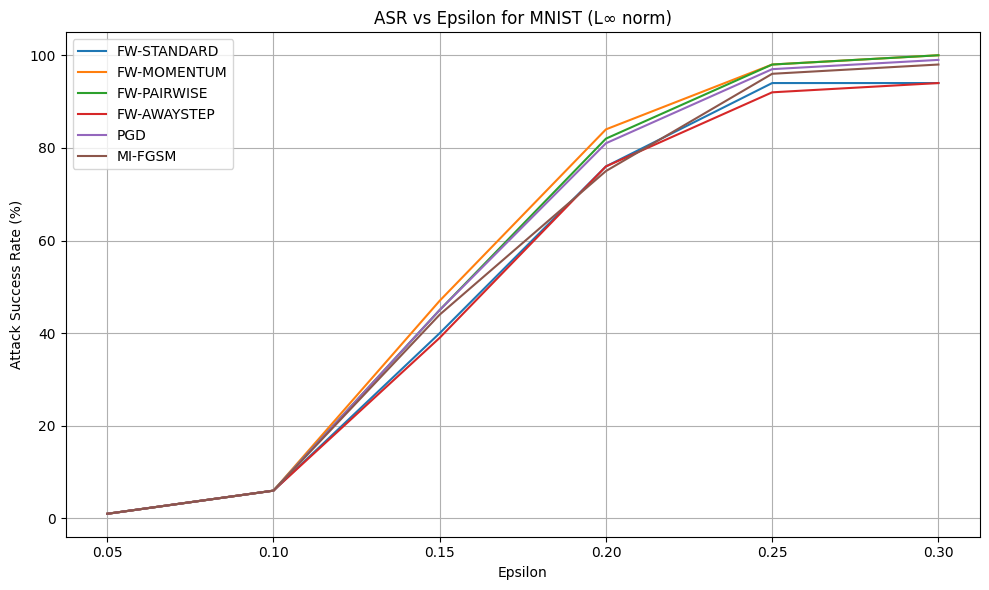

In [ ]:
plot_all_attacks_from_content()

### Visualize attack

Generating the visualization for the MNIST attack...


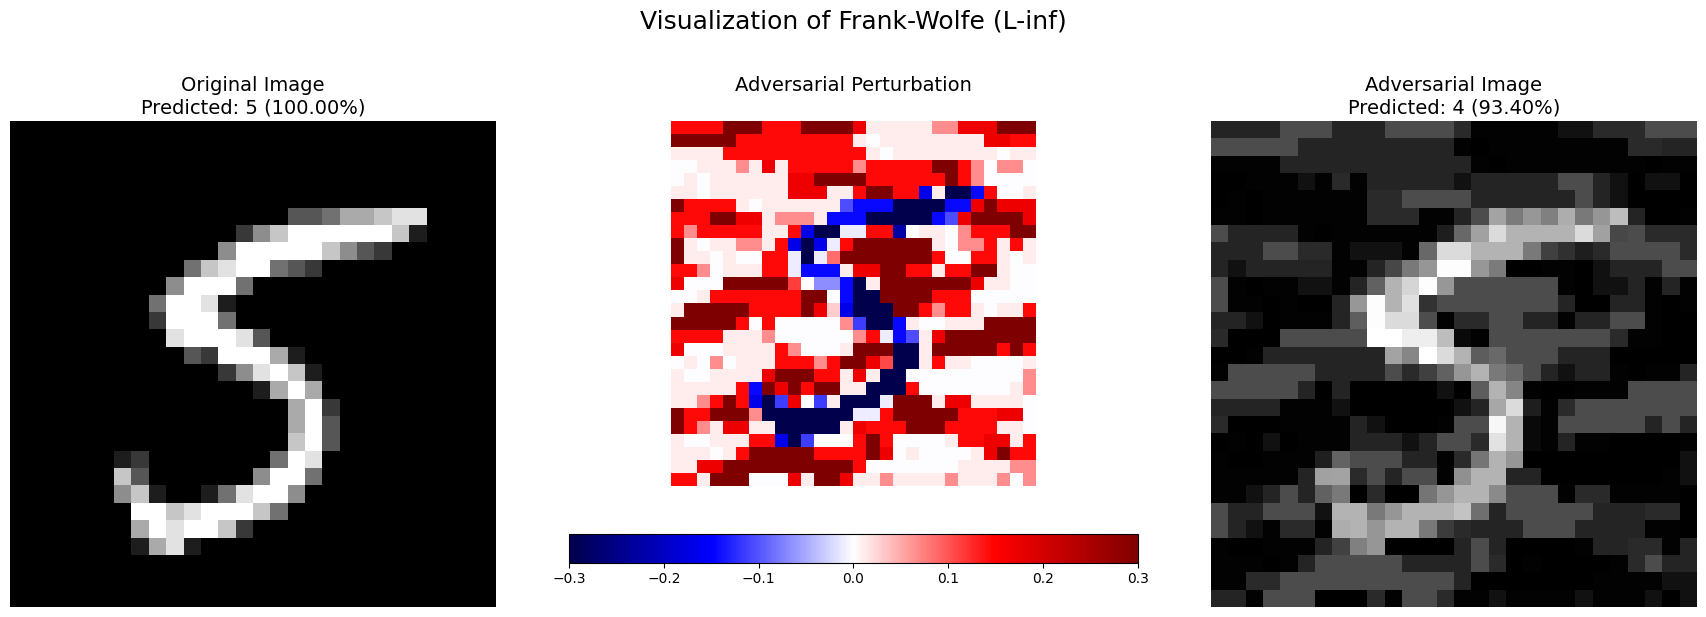

In [ ]:
model.to(device)

# Pick the first image from your list
image_to_attack = correctly_classified_images[0].unsqueeze(0).to(device)
original_label = original_labels[0].to(device)
target_label = target_labels[0].to(device)

# Run a single attack
adversarial_image, iters_taken = fw_standard(
    model=model,
    x_ori=image_to_attack,
    y_target=target_label,
    epsilon=0.30,
    num_iterations=40,
    norm='linf',
    stepsize_method='line_search'
)

# Call the visualization function
print("Generating the visualization for the MNIST attack...")
visualize_attack(
    model=model,
    original_image=image_to_attack,
    original_label=original_label,
    adversarial_image=adversarial_image,
    attack_name="Frank-Wolfe (L-inf)"
)

Generating the visualization for the MNIST attack...


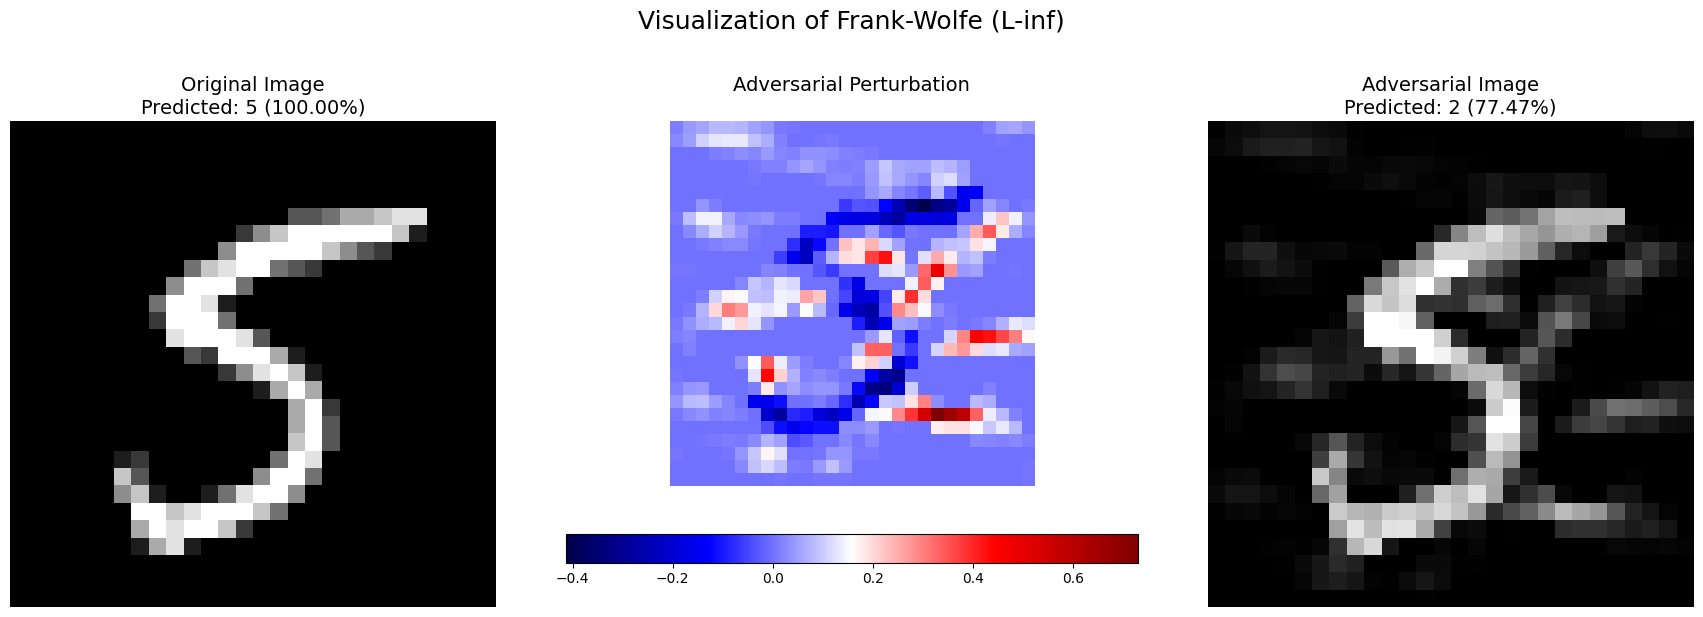

In [ ]:
# Pick the first image from your list
image_to_attack = correctly_classified_images[0].unsqueeze(0).to(device)
original_label = original_labels[0].to(device)
target_label = target_labels[0].to(device)

# Run a single attack
adversarial_image, iters_taken = fw_standard(
    model=model,
    x_ori=image_to_attack,
    y_target=target_label,
    epsilon=3.5,
    num_iterations=40,
    norm='l2',
    stepsize_method='line_search'
)

# Call the visualization function
print("Generating the visualization for the MNIST attack...")
visualize_attack(
    model=model,
    original_image=image_to_attack,
    original_label=original_label,
    adversarial_image=adversarial_image,
    attack_name="Frank-Wolfe (L-inf)"
)

## Run Frank-Wolfe standard

In [ ]:
norms = ['linf', 'l2']
stepsize_methods = ['decreasing', 'line_search']
stopping_criteria = ['success', 'duality_gap']

for norm in norms:
    for stepsize in stepsize_methods:
        for stop in stopping_criteria:
            run_attack_and_summarize(
                attack_fn=fw_standard,
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=0.3 if norm == 'linf' else 3.5,
                num_iterations=40,
                norm=norm,
                visualize=False,
                stepsize_method=stepsize,
                stopping_criterion=stop,
                num_line_search_steps=10,
                **({'duality_gap_threshold': 1e-4} if stop == 'duality_gap' else {})
            )


--- Summary: FW-STANDARD (LINF) | decreasing | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      100.00     0.3000               3.56                
Total time for all images: 1.22 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (LINF) | decreasing | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      100.00     0.3000               23.92               
Total time for all images: 5.74 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      94.00      0.2839               4.39                
Total time for all images: 4.54 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (LINF) | line_search | duality_gap ---
Epsilon    ASR (%)    Avg. Distor

## Run Frank-Wolfe with momentum

In [ ]:
norms = ['linf', 'l2']
stepsize_methods = ['decreasing', 'line_search']
stopping_criteria = ['success', 'duality_gap']

for norm in norms:
    for stepsize in stepsize_methods:
        for stop in stopping_criteria:
            run_attack_and_summarize(
                attack_fn=fw_momentum,
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=0.3 if norm == 'linf' else 3.5,
                num_iterations=40,
                norm=norm,
                visualize=False,
                stepsize_method=stepsize,
                stopping_criterion=stop,
                num_line_search_steps=10,
                beta=0.9,
                **({'duality_gap_threshold': 1e-4} if stop == 'duality_gap' else {})
            )


--- Summary: FW-STANDARD (MOMENTUM) (LINF) | decreasing | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      100.00     0.3000               2.75                
Total time for all images: 1.22 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | decreasing | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      100.00     0.3000               39.62               
Total time for all images: 9.61 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      100.00     0.2894               2.46                
Total time for all images: 2.91 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | duali

## Run Pairwise Frank-Wolfe

In [ ]:
norms = ['linf', 'l2']
stepsize_methods = ['decreasing', 'line_search']
stopping_criteria = ['success', 'duality_gap']

for norm in norms:
    for stepsize in stepsize_methods:
        for stop in stopping_criteria:
            run_attack_and_summarize(
                attack_fn=fw_pairwise,
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=0.3 if norm == 'linf' else 3.5,
                num_iterations=40,
                norm=norm,
                visualize=False,
                stepsize_method=stepsize,
                stopping_criterion=stop,
                num_line_search_steps=10,
                **({'duality_gap_threshold': 1e-4} if stop == 'duality_gap' else {})
            )


--- Summary: FW-PAIRWISE (LINF) | decreasing | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      99.00      0.3000               3.86                
Total time for all images: 1.69 seconds
----------------------------------------------------------------------

--- Summary: FW-PAIRWISE (LINF) | decreasing | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      99.00      0.3000               23.16               
Total time for all images: 11.85 seconds
----------------------------------------------------------------------

--- Summary: FW-PAIRWISE (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      100.00     0.2886               2.70                
Total time for all images: 3.11 seconds
----------------------------------------------------------------------

--- Summary: FW-PAIRWISE (LINF) | line_search | duality_gap ---
Epsilon    ASR (%)    Avg. Disto

## Run Away-Step Frank-Wolfe

In [ ]:
norms = ['linf', 'l2']
stepsize_methods = ['decreasing', 'line_search']
stopping_criteria = ['success', 'duality_gap']

for norm in norms:
    for stepsize in stepsize_methods:
        for stop in stopping_criteria:
            run_attack_and_summarize(
                attack_fn=fw_away_step,
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=0.3 if norm == 'linf' else 3.5,
                num_iterations=40,
                norm=norm,
                visualize=False,
                stepsize_method=stepsize,
                stopping_criterion=stop,
                num_line_search_steps=10,
                **({'duality_gap_threshold': 1e-4} if stop == 'duality_gap' else {})
            )


--- Summary: FW-AFW (LINF) | decreasing | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      80.00      0.3000               4.56                
Total time for all images: 1.72 seconds
----------------------------------------------------------------------

--- Summary: FW-AFW (LINF) | decreasing | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      100.00     0.3002               23.93               
Total time for all images: 14.38 seconds
----------------------------------------------------------------------

--- Summary: FW-AFW (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      94.00      0.2881               5.33                
Total time for all images: 5.73 seconds
----------------------------------------------------------------------

--- Summary: FW-AFW (LINF) | line_search | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iter

## Run Projected Gradient Descent

In [ ]:
epsilon_linf = 0.3
epsilon_l2 = 3.5
alpha_linf = 0.01
alpha_l2 = 0.125
num_iterations = 40
num_line_search_steps = 10
rho_tolerance = 1e-5

norms = ['linf', 'l2']
attack_types = ['pgd', 'mi_fgsm']
stopping_criteria = ['success', 'rho']

for norm in norms:
    epsilon = epsilon_linf if norm == 'linf' else epsilon_l2
    alpha = alpha_linf if norm == 'linf' else alpha_l2

    for attack_type in attack_types:
        mu = 0.9 if attack_type == 'mi_fgsm' else 1.0

        for stop in stopping_criteria:
            run_attack_and_summarize_pgd(
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=epsilon,
                num_iterations=num_iterations,
                alpha=alpha,
                norm=norm,
                attack_type=attack_type,
                mu=mu,
                stepsize_method='line_search',
                stopping_criterion=stop,
                rho_tolerance=rho_tolerance,
                num_line_search_steps=num_line_search_steps
            )


--- Summary: PGD (LINF) | α=0.01 | μ=N/A | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      99.00      0.1847               17.67               
Total time for all images: 21.59 seconds
----------------------------------------------------------------------

--- Summary: PGD (LINF) | α=0.01 | μ=N/A | stepsize=line_search | stop=rho ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      99.00      0.2952               37.02               
Total time for all images: 43.67 seconds
----------------------------------------------------------------------

--- Summary: MI_FGSM (LINF) | α=0.01 | μ=0.9 | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.300      98.00      0.1950               18.84               
Total time for all images: 23.58 seconds
----------------------------------------------------------------------

--- Summary: MI_FGSM (LINF)

# Attacking a ResNet18 model pre-trained on ImageNet

## Setup

In [20]:
# Unzip
!unzip "/content/ImageNet_Subset_1000.zip" -d "/content"

Archive:  /content/ImageNet_Subset_1000.zip
   creating: /content/kaggle/working/imagenet_subset_1000/
   creating: /content/kaggle/working/imagenet_subset_1000/n02509815/
  inflating: /content/kaggle/working/imagenet_subset_1000/n02509815/ILSVRC2012_val_00012160.JPEG  
   creating: /content/kaggle/working/imagenet_subset_1000/n04357314/
  inflating: /content/kaggle/working/imagenet_subset_1000/n04357314/ILSVRC2012_val_00008617.JPEG  
   creating: /content/kaggle/working/imagenet_subset_1000/n01644373/
  inflating: /content/kaggle/working/imagenet_subset_1000/n01644373/ILSVRC2012_val_00048482.JPEG  
   creating: /content/kaggle/working/imagenet_subset_1000/n04044716/
  inflating: /content/kaggle/working/imagenet_subset_1000/n04044716/ILSVRC2012_val_00039752.JPEG  
  inflating: /content/kaggle/working/imagenet_subset_1000/n04044716/ILSVRC2012_val_00018679.JPEG  
   creating: /content/kaggle/working/imagenet_subset_1000/n04326547/
  inflating: /content/kaggle/working/imagenet_subset_1000

In [40]:
# Loading the official ImageNet class index mapping
# This maps the output of the ResNet model (e.g., 292) to its synset ID (e.g., 'n02129165')
imagenet_class_url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
response = requests.get(imagenet_class_url)
imagenet_labels = json.loads(response.text)

# Define the normalization layer
# Using standard ImageNet mean and std
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Reshape mean and std to fit the image dimensions for broadcasting
mean = mean.view(1, 3, 1, 1)
std = std.view(1, 3, 1, 1)

# Creating a wrapper model that includes normalization
class NormalizedModel(nn.Module):
    def __init__(self, model):
        super(NormalizedModel, self).__init__()
        self.model = model

    def forward(self, x):
        # Apply normalization before passing the input to the model
        x_normalized = (x - mean) / std
        return self.model(x_normalized)

# Load the original pre-train ResNet-18 model
original_model = models.resnet18(pretrained=True).to(device)
original_model.eval()

# Wrap the original model with normalization layer
model = NormalizedModel(original_model)
model.eval()

# Preprocessing without normalization
preprocess_for_attack = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Create the dataloader with the new preprocessing
imagenet_val_subset = datasets.ImageFolder(
    root="/content/kaggle/working/imagenet_subset_1000",
    transform=preprocess_for_attack
)
dataloader = DataLoader(imagenet_val_subset, batch_size=1, shuffle=True)

# Create a mapping from the dataloader's index to its class name (synset ID)
idx_to_class = {v: k for k, v in imagenet_val_subset.class_to_idx.items()}


# --- Select Images for Attack ---
num_images_to_attack = 100
num_classes = 1000
correctly_classified_images = []
original_labels = []
target_labels = []

print("Selecting correctly classified images for the attack...")
for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # Compare the synset ID from the model's prediction with the ground truth synset ID
    predicted_synset = imagenet_labels[str(predicted.item())][0]
    actual_synset = idx_to_class[labels.item()]

    if predicted_synset == actual_synset:
        correctly_classified_images.append(images)
        original_labels.append(labels)

        # Assign a random target class
        while True:
            # Finding a random target that is not the current class
            random_target_idx = random.randint(0, num_classes - 1)
            # Ensure the random target's synset is different from the original
            if imagenet_labels[str(random_target_idx)][0] != actual_synset:
                target_labels.append(torch.tensor([random_target_idx]).to(device))
                break

    if len(correctly_classified_images) >= num_images_to_attack:
        break

print(f"Selected {len(correctly_classified_images)} images.")

Selecting correctly classified images for the attack...
Selected 100 images.


In [ ]:
# Define attack parameters for ImageNet
epsilon_linf = 0.01
epsilon_l2 = 1.0

num_iterations = 40

alpha_linf = 0.078
alpha_l2 = 0.05

# Initialize storage for results
results_imagenet = {
    'FW-Linf': {'success': [], 'distortion': [], 'iterations': []},
    'FW-L2': {'success': [], 'distortion': [], 'iterations': []},
    'PGD-Linf': {'success': [], 'distortion': [], 'iterations': []},
    'PGD-L2': {'success': [], 'distortion': [], 'iterations': []},
}

## Functions to run attacks and summarize the results

In [22]:
def run_attack_and_summarize(
    attack_fn,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilon,
    num_iterations,
    norm,
    attack_name=None,
    visualize=True,
    **attack_kwargs
):
    if attack_name is None:
        fn_name = attack_fn.__name__.lower()
        step = attack_kwargs.get('stepsize_method', 'N/A')
        stop = attack_kwargs.get('stopping_criterion', 'N/A')
        norm_upper = norm.upper()

        if 'momentum' in fn_name:
            attack_name = f"FW-STANDARD (MOMENTUM) ({norm_upper}) | {step} | {stop}"
        elif 'standard' in fn_name:
            attack_name = f"FW-STANDARD ({norm_upper}) | {step} | {stop}"
        elif 'pgd' in fn_name:
            variant = attack_kwargs.get('attack_type', 'PGD').upper()
            attack_name = f"{variant} ({norm_upper})"
        elif 'pairwise' in fn_name:
            attack_name = f"FW-PAIRWISE ({norm_upper}) | {step} | {stop}"
        elif 'away' in fn_name:
            attack_name = f"FW-AFW ({norm_upper}) | {step} | {stop}"
        else:
            attack_name = f"{fn_name.upper()} ({norm_upper})"

    results = {'success': [], 'distortion': [], 'iterations': []}
    visualized = False

    start_time = time.time()

    for i in range(len(correctly_classified_images)):
        x_ori = correctly_classified_images[i]
        # Add batch dimension if missing
        if x_ori.dim() == 3:
            x_ori = x_ori.unsqueeze(0)

        y_ori = original_labels[i]
        y_target = target_labels[i]

        adv_x, iters = attack_fn(
            model=model,
            x_ori=x_ori,
            y_target=y_target,
            epsilon=epsilon,
            num_iterations=num_iterations,
            norm=norm,
            **attack_kwargs
        )

        with torch.no_grad():
            success = (model(adv_x).argmax() == y_target).item()
        results['success'].append(success)

        # Compute distortion
        if norm == 'linf':
            distortion = torch.max(torch.abs(adv_x - x_ori)).item()
        else:
            distortion = torch.linalg.norm((adv_x - x_ori).flatten()).item()
        results['distortion'].append(distortion)
        results['iterations'].append(iters)

        if visualize and not visualized:
            visualize_attack(model, x_ori, y_ori, adv_x, attack_name=attack_name)
            visualized = True

    total_time = time.time() - start_time

    # --- Summary ---
    summary = {
        'asr': 100 * np.mean(results['success']),
        'dist': np.mean(results['distortion']),
        'iters': np.mean(results['iterations'])
    }

    print(f"\n--- Summary: {attack_name} ---")
    print(f"{'Epsilon':<10} {'ASR (%)':<10} {'Avg. Distortion':<20} {'Avg. Iterations':<20}")
    print(f"{epsilon:<10.3f} {summary['asr']:<10.2f} {summary['dist']:<20.4f} {summary['iters']:<20.2f}")
    print(f"Total time for all images: {total_time:.2f} seconds")
    print("-" * 70)

    return summary

In [ ]:
def run_attack_and_summarize_pgd_imagenet(
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilon,
    num_iterations,
    alpha,
    norm,
    attack_type,
    mu=1.0,
    imagenet_labels=None,
    visualize=True,
    stepsize_method='fixed',
    stopping_criterion='success',
    rho_tolerance=1e-4,
    num_line_search_steps=10
):
    results = {'success': [], 'distortion': [], 'iterations': []}
    attack_name = (
        f"{attack_type.upper()} ({norm.upper()}) | "
        f"α={alpha:.4f} | μ={mu if attack_type == 'mi_fgsm' else 'N/A'} | "
        f"stepsize={stepsize_method} | stop={stopping_criterion}"
    )
    start_time = time.time()
    visualized = False

    for i in range(len(correctly_classified_images)):
        x_ori = correctly_classified_images[i]
        y_ori = original_labels[i]
        y_target = target_labels[i]

        adv_x, iters = pgd_attack(
            model=model,
            x_ori=x_ori,
            y_target=y_target,
            epsilon=epsilon,
            num_iterations=num_iterations,
            alpha=alpha,
            norm=norm,
            attack_type=attack_type,
            mu=mu,
            stepsize_method=stepsize_method,
            stopping_criterion=stopping_criterion,
            rho_tolerance=rho_tolerance,
            num_line_search_steps=num_line_search_steps
        )

        with torch.no_grad():
            success = (model(adv_x).argmax() == y_target).item()
        results['success'].append(success)

        # Distortion calculation
        if norm == 'linf':
            distortion = torch.max(torch.abs(adv_x - x_ori)).item()
        else:
            distortion = torch.linalg.norm((adv_x - x_ori).flatten()).item()

        results['distortion'].append(distortion)
        results['iterations'].append(iters)

        # Optional visualization
        if visualize and not visualized and imagenet_labels is not None:
            visualize_attack_imagenet(
                model, x_ori, adv_x, y_ori, y_target, imagenet_labels,
                attack_name=attack_name
            )
            visualized = True

    total_time = time.time() - start_time
    summary = {
        'asr': 100 * np.mean(results['success']),
        'dist': np.mean(results['distortion']),
        'iters': np.mean(results['iterations'])
    }

    print(f"\n--- Summary: {attack_name} ---")
    print(f"{'Epsilon':<10} {'ASR (%)':<10} {'Avg. Distortion':<20} {'Avg. Iterations':<20}")
    print(f"{epsilon:<10.4f} {summary['asr']:<10.2f} {summary['dist']:<20.4f} {summary['iters']:<20.2f}")
    print(f"Total time for all images: {total_time:.2f} seconds")
    print("-" * 70)

    return summary


## Success rate vs. epsilon

### Run all the algorithms using different values of epsilon

In [24]:
def run_attack_epsilon(
    attack_name,
    attack_fn,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    num_iterations=40,
    epsilons=np.arange(0.001, 0.012, 0.002),
    norm='linf',
    file_prefix='results_linf',
    extra_attack_kwargs=None
):
    results = {
        'epsilon': [],
        attack_name: []
    }

    extra_attack_kwargs = extra_attack_kwargs or {}

    for epsilon in epsilons:
        print(f"\n--- {attack_name.upper()} | Epsilon = {epsilon:.3f} ---")
        results['epsilon'].append(epsilon)

        res = run_attack_and_summarize(
            attack_fn=attack_fn,
            model=model,
            correctly_classified_images=correctly_classified_images,
            original_labels=original_labels,
            target_labels=target_labels,
            epsilon=epsilon,
            num_iterations=num_iterations,
            norm=norm,
            visualize=False,
            **extra_attack_kwargs
        )

        results[attack_name].append(res['asr'])

    # Save to file
    os.makedirs("/content", exist_ok=True)
    filename = f"/content/{file_prefix}_{attack_name}.json"
    with open(filename, 'w') as f:
        json.dump(results, f)

    print(f"\n Saved results to {filename}")
    return results

epsilons = np.arange(0.001, 0.014, 0.002)

In [ ]:
# FW-Standard
run_attack_epsilon(
    'fw_standard',
    fw_standard,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilons=epsilons,
    extra_attack_kwargs={
        'stepsize_method': 'line_search',
        'stopping_criterion': 'success',
        'num_line_search_steps': 10
    }
)


--- FW_STANDARD | Epsilon = 0.001 ---

--- Summary: FW-STANDARD (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.001      3.00       0.0010               39.18               
Total time for all images: 176.76 seconds
----------------------------------------------------------------------

--- FW_STANDARD | Epsilon = 0.003 ---

--- Summary: FW-STANDARD (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.003      70.00      0.0030               16.07               
Total time for all images: 73.67 seconds
----------------------------------------------------------------------

--- FW_STANDARD | Epsilon = 0.005 ---

--- Summary: FW-STANDARD (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      98.00      0.0050               4.78                
Total time for all images: 22.74 seconds
--------------------------------------------------

{'epsilon': [np.float64(0.001),
  np.float64(0.003),
  np.float64(0.005),
  np.float64(0.007),
  np.float64(0.009000000000000001),
  np.float64(0.011),
  np.float64(0.013000000000000001)],
 'fw_standard': [np.float64(3.0),
  np.float64(70.0),
  np.float64(98.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0)]}

In [ ]:
# FW-Momentum
run_attack_epsilon(
    'fw_momentum',
    fw_momentum,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilons=epsilons,
    extra_attack_kwargs={
        'stepsize_method': 'line_search',
        'stopping_criterion': 'success',
        'num_line_search_steps': 10,
        'beta': 0.9
    }
)


--- FW_MOMENTUM | Epsilon = 0.001 ---

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.001      3.00       0.0010               39.11               
Total time for all images: 177.19 seconds
----------------------------------------------------------------------

--- FW_MOMENTUM | Epsilon = 0.003 ---

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.003      79.00      0.0030               17.96               
Total time for all images: 82.86 seconds
----------------------------------------------------------------------

--- FW_MOMENTUM | Epsilon = 0.005 ---

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               7.39                
Total time for all images: 35.44 seconds
-----------------

{'epsilon': [np.float64(0.001),
  np.float64(0.003),
  np.float64(0.005),
  np.float64(0.007),
  np.float64(0.009000000000000001),
  np.float64(0.011),
  np.float64(0.013000000000000001)],
 'fw_momentum': [np.float64(3.0),
  np.float64(79.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0)]}

In [ ]:
# Pairwise FW
run_attack_epsilon(
    'fw_pairwise',
    fw_pairwise,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilons=epsilons,
    extra_attack_kwargs={
        'stepsize_method': 'line_search',
        'stopping_criterion': 'success',
        'num_line_search_steps': 10
    }
)


--- FW_PAIRWISE | Epsilon = 0.001 ---

--- Summary: FW-PAIRWISE (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.001      3.00       0.0010               39.19               
Total time for all images: 185.56 seconds
----------------------------------------------------------------------

--- FW_PAIRWISE | Epsilon = 0.003 ---

--- Summary: FW-PAIRWISE (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.003      72.00      0.0030               16.29               
Total time for all images: 78.35 seconds
----------------------------------------------------------------------

--- FW_PAIRWISE | Epsilon = 0.005 ---

--- Summary: FW-PAIRWISE (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      99.00      0.0050               4.72                
Total time for all images: 23.07 seconds
--------------------------------------------------

{'epsilon': [np.float64(0.001),
  np.float64(0.003),
  np.float64(0.005),
  np.float64(0.007),
  np.float64(0.009000000000000001),
  np.float64(0.011),
  np.float64(0.013000000000000001)],
 'fw_pairwise': [np.float64(3.0),
  np.float64(72.0),
  np.float64(99.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0)]}

In [ ]:
# Away Step
run_attack_epsilon(
    'fw_awaystep',
    fw_away_step,
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    epsilons=epsilons,
    extra_attack_kwargs={
        'stepsize_method': 'line_search',
        'stopping_criterion': 'success',
        'num_line_search_steps': 10
    }
)


--- FW_AWAYSTEP | Epsilon = 0.001 ---

--- Summary: FW-AFW (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.001      3.00       0.0010               39.21               
Total time for all images: 187.60 seconds
----------------------------------------------------------------------

--- FW_AWAYSTEP | Epsilon = 0.003 ---

--- Summary: FW-AFW (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.003      67.00      0.0030               16.83               
Total time for all images: 80.87 seconds
----------------------------------------------------------------------

--- FW_AWAYSTEP | Epsilon = 0.005 ---

--- Summary: FW-AFW (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      97.00      0.0050               5.56                
Total time for all images: 26.02 seconds
-----------------------------------------------------------------

{'epsilon': [np.float64(0.001),
  np.float64(0.003),
  np.float64(0.005),
  np.float64(0.007),
  np.float64(0.009000000000000001),
  np.float64(0.011),
  np.float64(0.013000000000000001)],
 'fw_awaystep': [np.float64(3.0),
  np.float64(67.0),
  np.float64(97.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0)]}

In [37]:
def run_attack_epsilon_pgd(
    model,
    correctly_classified_images,
    original_labels,
    target_labels,
    num_iterations=40,
    epsilons=np.arange(0.001, 0.014, 0.002),
    file_prefix='results_linf',
    norm='linf',
    attack_type='pgd',
    alpha=0.0078,
    mu=0.9,
    stopping_criterion='success',
    rho_tolerance=1e-4,
    num_line_search_steps=10
):
    results = {
        'epsilon': [],
        f"{attack_type}_{stopping_criterion}": []
    }

    for epsilon in epsilons:
        print(f"\n--- {attack_type.upper()} | Epsilon = {epsilon:.4f} ---")
        results['epsilon'].append(epsilon)

        res = run_attack_and_summarize_pgd_imagenet(
            model=model,
            correctly_classified_images=correctly_classified_images,
            original_labels=original_labels,
            target_labels=target_labels,
            epsilon=epsilon,
            num_iterations=num_iterations,
            alpha=alpha,
            norm=norm,
            attack_type=attack_type,
            mu=mu,
            stepsize_method='line_search',
            stopping_criterion=stopping_criterion,
            rho_tolerance=rho_tolerance,
            num_line_search_steps=num_line_search_steps
        )

        results[f"{attack_type}_{stopping_criterion}"].append(res['asr'])

    # Save results
    os.makedirs("/content", exist_ok=True)
    filename = f"/content/{file_prefix}_{attack_type}_{stopping_criterion}.json"
    with open(filename, 'w') as f:
        json.dump(results, f)

    print(f"\nSaved results to {filename}")
    return results

In [ ]:
run_attack_epsilon_pgd(
    model=model,
    correctly_classified_images=correctly_classified_images,
    original_labels=original_labels,
    target_labels=target_labels,
    epsilons=epsilons,
    file_prefix='results_linf',
    norm='linf',
    attack_type='pgd',
    alpha=0.0078,
    mu=1.0,
    stopping_criterion='success',
    rho_tolerance=1e-4,
    num_line_search_steps=10
)


--- PGD | Epsilon = 0.0010 ---

--- Summary: PGD (LINF) | α=0.0078 | μ=N/A | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0010     1.00       0.0010               39.62               
Total time for all images: 224.80 seconds
----------------------------------------------------------------------

--- PGD | Epsilon = 0.0030 ---

--- Summary: PGD (LINF) | α=0.0078 | μ=N/A | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0030     72.00      0.0030               13.84               
Total time for all images: 82.31 seconds
----------------------------------------------------------------------

--- PGD | Epsilon = 0.0050 ---

--- Summary: PGD (LINF) | α=0.0078 | μ=N/A | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0050     99.00      0.0050               2.88                
Total time for all images: 22.25 seco

{'epsilon': [np.float64(0.001),
  np.float64(0.003),
  np.float64(0.005),
  np.float64(0.007),
  np.float64(0.009000000000000001),
  np.float64(0.011),
  np.float64(0.013000000000000001)],
 'pgd_success': [np.float64(1.0),
  np.float64(72.0),
  np.float64(99.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0)]}

In [ ]:
run_attack_epsilon_pgd(
    model=model,
    correctly_classified_images=correctly_classified_images,
    original_labels=original_labels,
    target_labels=target_labels,
    epsilons=epsilons,
    file_prefix='results_linf',
    norm='linf',
    attack_type='mi_fgsm',
    alpha=0.0078,
    mu=0.9,
    stopping_criterion='success',
    rho_tolerance=1e-4,
    num_line_search_steps=10
)


--- MI_FGSM | Epsilon = 0.0010 ---

--- Summary: MI_FGSM (LINF) | α=0.0075 | μ=0.9 | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0010     3.00       0.0010               38.90               
Total time for all images: 221.95 seconds
----------------------------------------------------------------------

--- MI_FGSM | Epsilon = 0.0030 ---

--- Summary: MI_FGSM (LINF) | α=0.0075 | μ=0.9 | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0030     81.00      0.0030               10.83               
Total time for all images: 66.52 seconds
----------------------------------------------------------------------

--- MI_FGSM | Epsilon = 0.0050 ---

--- Summary: MI_FGSM (LINF) | α=0.0075 | μ=0.9 | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0050     100.00     0.0050               2.03                
Total time fo

{'epsilon': [np.float64(0.001),
  np.float64(0.003),
  np.float64(0.005),
  np.float64(0.007),
  np.float64(0.009000000000000001),
  np.float64(0.011),
  np.float64(0.013000000000000001)],
 'mi_fgsm_success': [np.float64(3.0),
  np.float64(81.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0),
  np.float64(100.0)]}

### Plot

In [ ]:
def plot_all_attacks_from_content(file_dir="/content", title="ASR vs Epsilon for ImageNet (L∞ norm)"):
    method_map = {
        "fw_standard": "results_linf_fw_standard.json",
        "fw_momentum": "results_linf_fw_momentum.json",
        "fw_pairwise": "results_linf_fw_pairwise.json",
        "fw_awaystep": "results_linf_fw_awaystep.json",
        "pgd_success": "results_linf_pgd_success.json",
        "mi_fgsm_success": "results_linf_mi_fgsm_success.json"
    }

    plt.figure(figsize=(10, 6))

    for method, filename in method_map.items():
        file_path = os.path.join(file_dir, filename)
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                data = json.load(f)
            plt.plot(data["epsilon"], data[method], label=method.replace('_', '-').upper())
        else:
            print(f"File not found: {file_path}")

    plt.title(title)
    plt.xlabel("Epsilon")
    plt.ylabel("Attack Success Rate (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

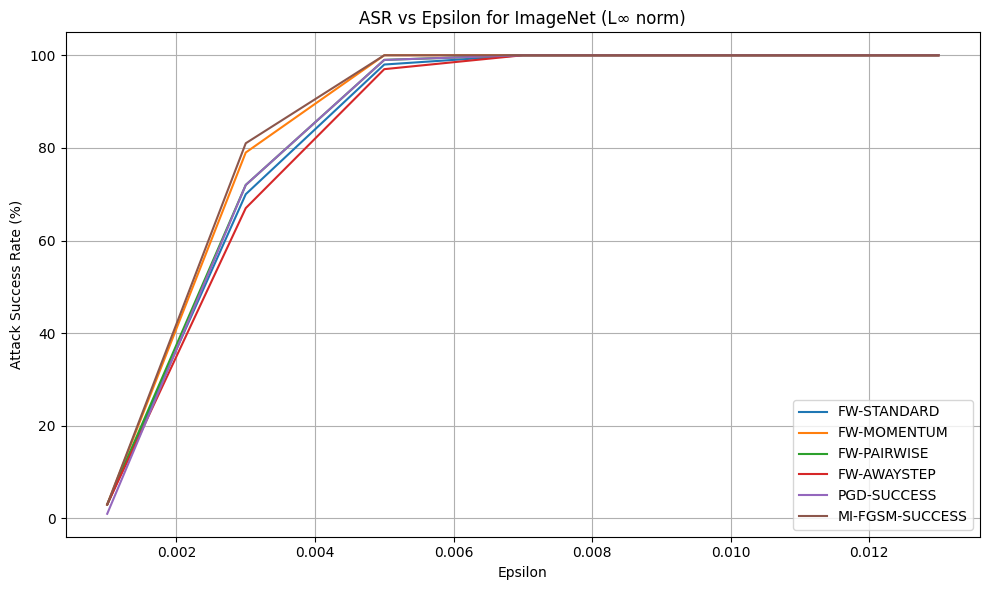

In [ ]:
plot_all_attacks_from_content()

### Visualize attacks

### $L_{\infty}$ vs $L2$


Generating the visualization for the ImageNet FW-Momentum attack...


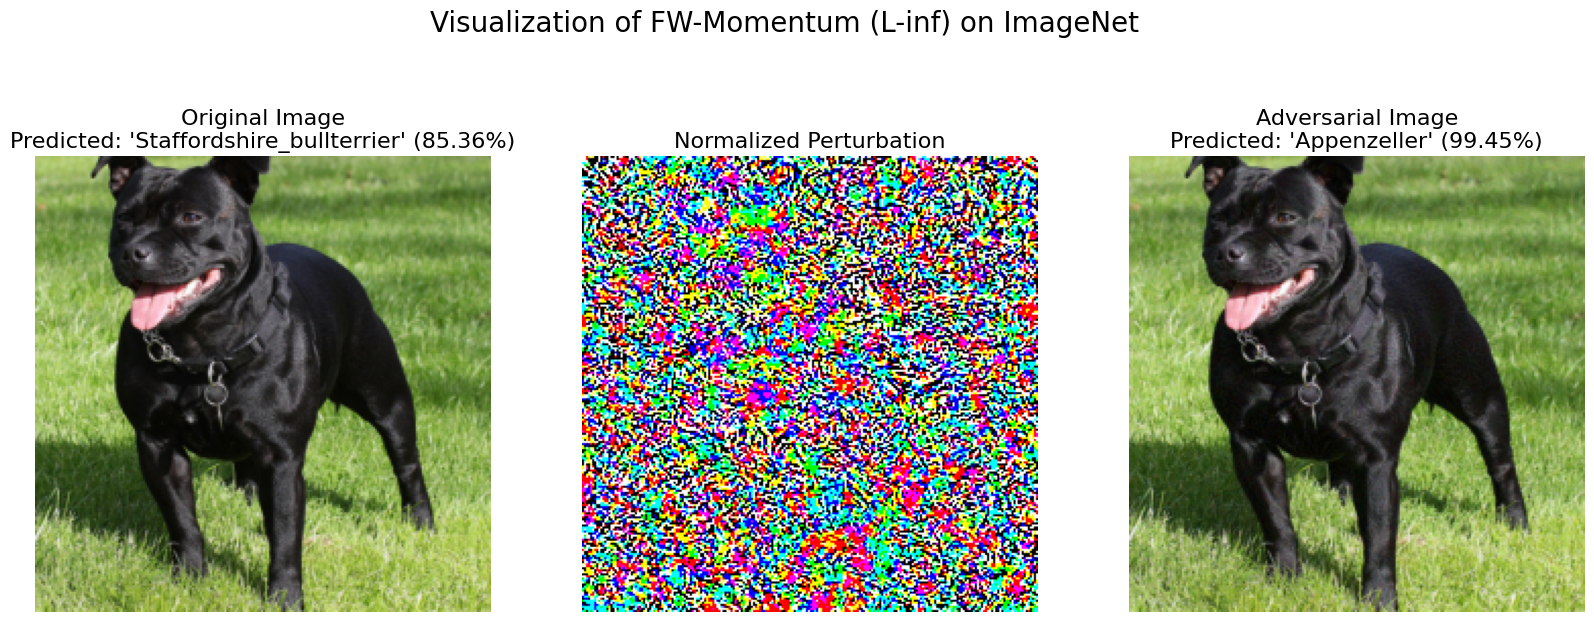

In [ ]:
# Select a single ImageNet image
image_to_attack_imagenet = correctly_classified_images[99].to(device)
original_label_imagenet = original_labels[99].to(device)
target_label_imagenet = target_labels[99].to(device)

# Run the FW-Momentum attack on the ImageNet image
adversarial_image_imagenet, iters_taken_imagenet = fw_momentum(
    model=model, # Use the NormalizedModel
    x_ori=image_to_attack_imagenet,
    y_target=target_label_imagenet,
    epsilon=0.01,
    num_iterations=40,
    beta=0.9,  # Momentum parameter
    norm='linf',
    stepsize_method='line_search',
    stopping_criterion='duality_gap',
    num_line_search_steps=10
)

# Call the visualization function
print("\nGenerating the visualization for the ImageNet FW-Momentum attack...")
visualize_attack_imagenet(
    model=model,
    original_image=image_to_attack_imagenet,
    adversarial_image=adversarial_image_imagenet,
    true_label_idx=original_label_imagenet,
    target_label_idx=target_label_imagenet,
    imagenet_labels=imagenet_labels,
    attack_name="FW-Momentum (L-inf)"
)


Generating the visualization for the ImageNet FW-Momentum attack...


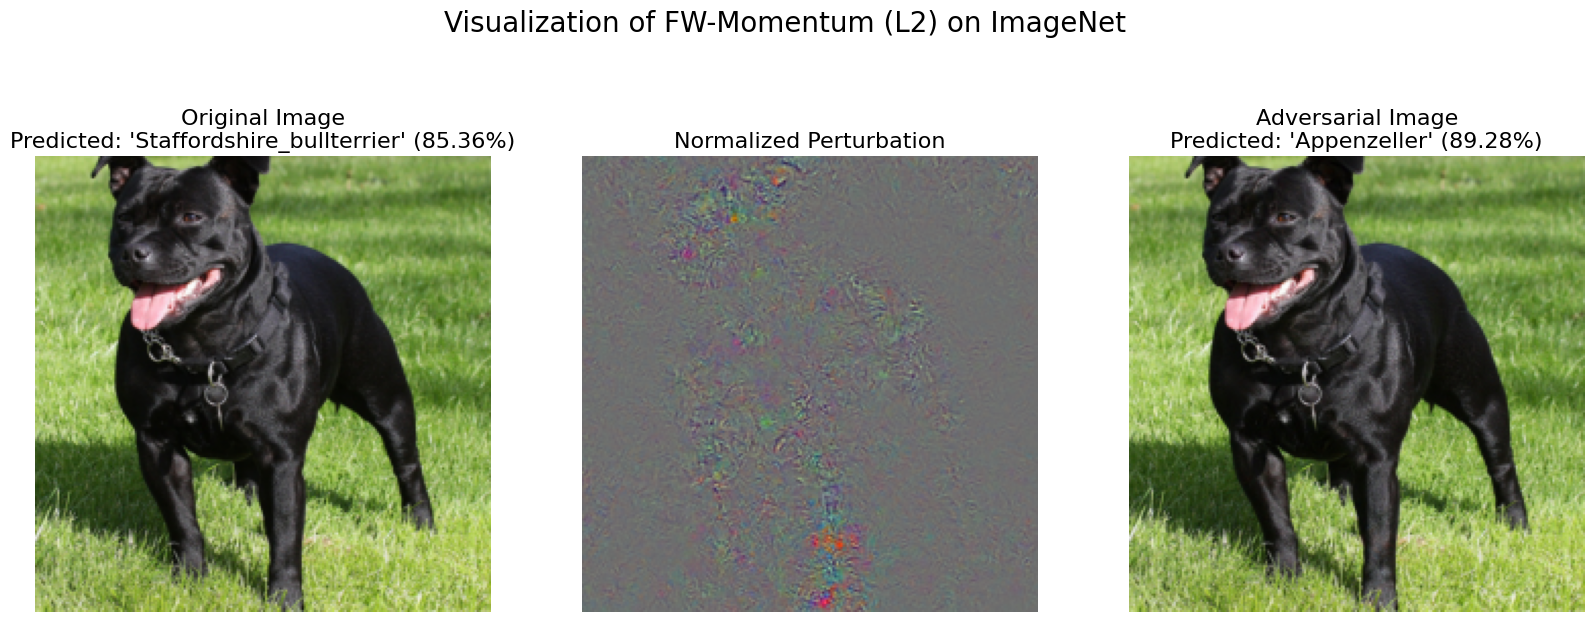

In [ ]:
# Select a single ImageNet image
image_to_attack_imagenet = correctly_classified_images[99].to(device)
original_label_imagenet = original_labels[99].to(device)
target_label_imagenet = target_labels[99].to(device)

# Run the FW-Momentum attack on the ImageNet image
adversarial_image_imagenet, iters_taken_imagenet = fw_momentum(
    model=model, # Use the NormalizedModel
    x_ori=image_to_attack_imagenet,
    y_target=target_label_imagenet,
    epsilon=1.0,  # Epsilon for L2 norm
    num_iterations=40,
    beta=0.9,
    norm='l2',  # Set norm to L2
    stepsize_method='line_search',
    stopping_criterion='duality_gap',
    num_line_search_steps=10
)

# Call the visualization function
print("\nGenerating the visualization for the ImageNet FW-Momentum attack...")
visualize_attack_imagenet(
    model=model,
    original_image=image_to_attack_imagenet,
    adversarial_image=adversarial_image_imagenet,
    true_label_idx=original_label_imagenet,
    target_label_idx=target_label_imagenet,
    imagenet_labels=imagenet_labels,
    attack_name="FW-Momentum (L2)"
)

### Duality Gap vs Success


Generating the visualization for the ImageNet FW-Momentum attack...


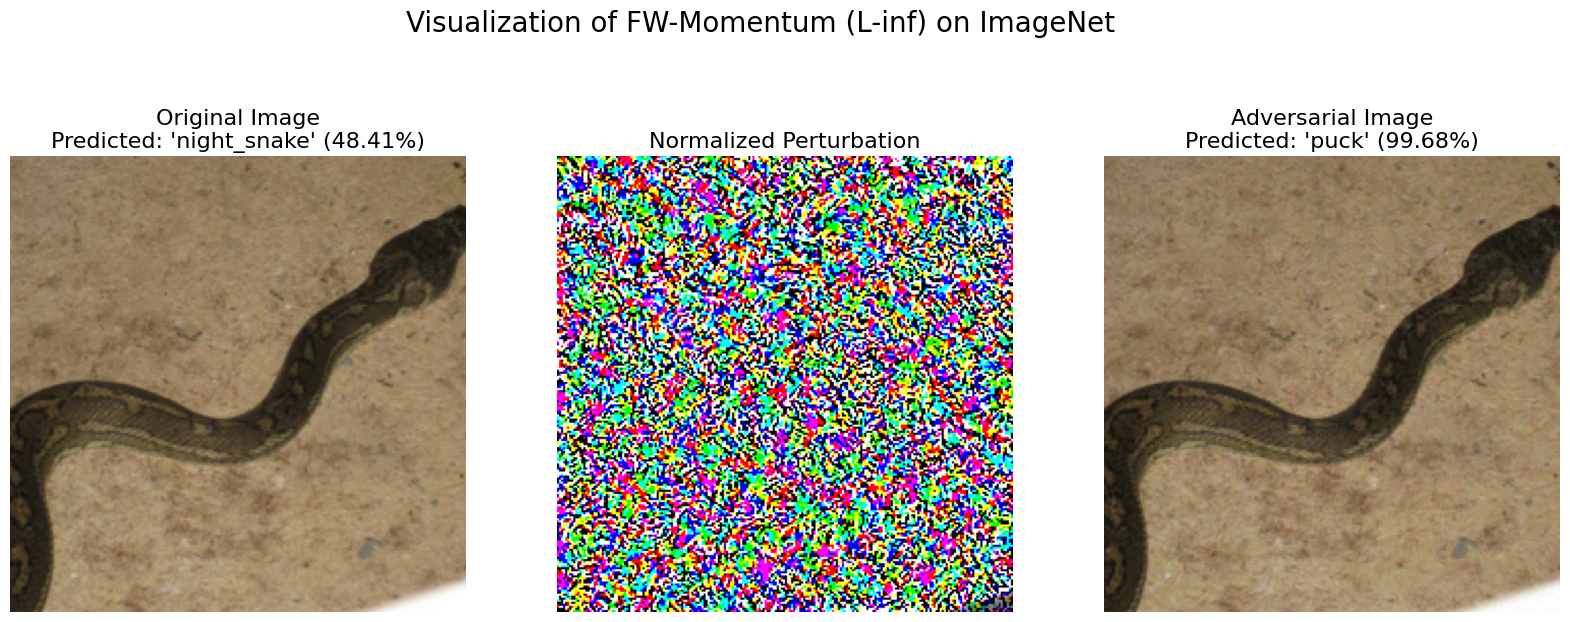

In [ ]:
# Select a single ImageNet image
image_to_attack_imagenet = correctly_classified_images[0].to(device)
original_label_imagenet = original_labels[0].to(device)
target_label_imagenet = target_labels[0].to(device)

# Run the FW-Momentum attack on the ImageNet image
adversarial_image_imagenet, iters_taken_imagenet = fw_momentum(
    model=model, # Use the NormalizedModel
    x_ori=image_to_attack_imagenet,
    y_target=target_label_imagenet,
    epsilon=0.01,
    num_iterations=40,
    beta=0.9,  # Momentum parameter
    norm='linf',
    stepsize_method='line_search',
    stopping_criterion='duality_gap',
    num_line_search_steps=10
)

# Call the visualization function
print("\nGenerating the visualization for the ImageNet FW-Momentum attack...")
visualize_attack_imagenet(
    model=model,
    original_image=image_to_attack_imagenet,
    adversarial_image=adversarial_image_imagenet,
    true_label_idx=original_label_imagenet,
    target_label_idx=target_label_imagenet,
    imagenet_labels=imagenet_labels,
    attack_name="FW-Momentum (L-inf)"
)


Generating the visualization for the ImageNet FW-Momentum attack...


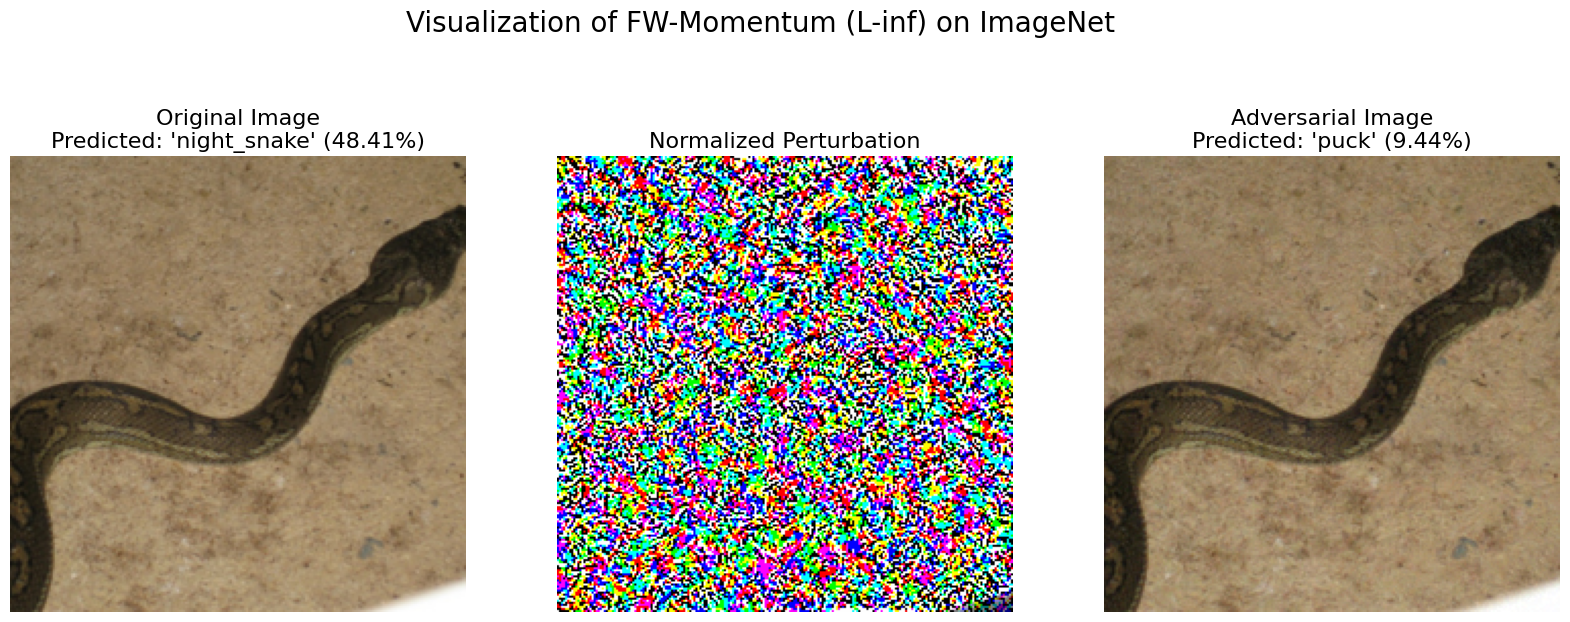

In [ ]:
# Select a single ImageNet image
image_to_attack_imagenet = correctly_classified_images[0].to(device)
original_label_imagenet = original_labels[0].to(device)
target_label_imagenet = target_labels[0].to(device)

# Run the FW-Momentum attack on the ImageNet image
adversarial_image_imagenet, iters_taken_imagenet = fw_momentum(
    model=model, # Use the NormalizedModel
    x_ori=image_to_attack_imagenet,
    y_target=target_label_imagenet,
    epsilon=0.01,
    num_iterations=40,
    beta=0.9,  # Momentum parameter
    norm='linf',
    stepsize_method='line_search',
    stopping_criterion='success',
    num_line_search_steps=10
)

# Call the visualization function
print("\nGenerating the visualization for the ImageNet FW-Momentum attack...")
visualize_attack_imagenet(
    model=model,
    original_image=image_to_attack_imagenet,
    adversarial_image=adversarial_image_imagenet,
    true_label_idx=original_label_imagenet,
    target_label_idx=target_label_imagenet,
    imagenet_labels=imagenet_labels,
    attack_name="FW-Momentum (L-inf)"
)

## Run Frank-Wolfe standard

In [35]:
# --- Define attack parameters for ImageNet ---
epsilon_linf = 0.005
epsilon_l2 = 1.0

num_iterations = 40

alpha_linf = 0.078
alpha_l2 = 0.05

# Initialize storage for results
results_imagenet = {
    'FW-Linf': {'success': [], 'distortion': [], 'iterations': []},
    'FW-L2': {'success': [], 'distortion': [], 'iterations': []},
    'PGD-Linf': {'success': [], 'distortion': [], 'iterations': []},
    'PGD-L2': {'success': [], 'distortion': [], 'iterations': []},
}

In [26]:
#FW Standard
norms = ['linf', 'l2']
stepsize_methods = ['decreasing', 'line_search']
stopping_criteria = ['success', 'duality_gap']

for norm in norms:
    for stepsize in stepsize_methods:
        for stop in stopping_criteria:
            epsilon = epsilon_linf if norm == 'linf' else epsilon_l2

            run_attack_and_summarize(
                attack_fn=fw_standard,
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=epsilon,
                num_iterations=num_iterations,
                norm=norm,
                visualize=False,
                stepsize_method=stepsize,
                stopping_criterion=stop,
                num_line_search_steps=10,
                **({'duality_gap_threshold': 1e-4} if stop == 'duality_gap' else {})
            )


--- Summary: FW-STANDARD (LINF) | decreasing | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               4.66                
Total time for all images: 5.65 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (LINF) | decreasing | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               36.65               
Total time for all images: 29.74 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               4.25                
Total time for all images: 17.87 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (LINF) | line_search | duality_gap ---
Epsilon    ASR (%)    Avg. Dist

## Run Frank-Wolfe with momentum

In [27]:
# FW momentum
norms = ['linf', 'l2']
stepsize_methods = ['decreasing', 'line_search']
stopping_criteria = ['success', 'duality_gap']

for norm in norms:
    for stepsize in stepsize_methods:
        for stop in stopping_criteria:
            epsilon = epsilon_linf if norm == 'linf' else epsilon_l2

            run_attack_and_summarize(
                attack_fn=fw_momentum,  # use the momentum version
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=epsilon,
                num_iterations=num_iterations,
                norm=norm,
                visualize=False,
                stepsize_method=stepsize,
                stopping_criterion=stop,
                num_line_search_steps=10,
                beta=0.9,  # momentum parameter
                **({'duality_gap_threshold': 1e-4} if stop == 'duality_gap' else {})
            )


--- Summary: FW-STANDARD (MOMENTUM) (LINF) | decreasing | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      98.00      0.0050               11.06               
Total time for all images: 10.82 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | decreasing | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      98.00      0.0050               40.00               
Total time for all images: 33.16 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               7.62                
Total time for all images: 31.93 seconds
----------------------------------------------------------------------

--- Summary: FW-STANDARD (MOMENTUM) (LINF) | line_search | du

## Run Pairwise Frank-Wolfe

In [28]:
# FW Pairwise
norms = ['linf', 'l2']
stepsize_methods = ['decreasing', 'line_search']
stopping_criteria = ['success', 'duality_gap']

for norm in norms:
    for stepsize in stepsize_methods:
        for stop in stopping_criteria:
            epsilon = epsilon_linf if norm == 'linf' else epsilon_l2

            run_attack_and_summarize(
                attack_fn=fw_pairwise,  # pairwise
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=epsilon,
                num_iterations=num_iterations,
                norm=norm,
                visualize=False,
                stepsize_method=stepsize,
                stopping_criterion=stop,
                num_line_search_steps=10,
                **({'duality_gap_threshold': 1e-4} if stop == 'duality_gap' else {})
            )


--- Summary: FW-PAIRWISE (LINF) | decreasing | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               5.83                
Total time for all images: 6.29 seconds
----------------------------------------------------------------------

--- Summary: FW-PAIRWISE (LINF) | decreasing | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               38.27               
Total time for all images: 41.23 seconds
----------------------------------------------------------------------

--- Summary: FW-PAIRWISE (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               4.61                
Total time for all images: 19.32 seconds
----------------------------------------------------------------------

--- Summary: FW-PAIRWISE (LINF) | line_search | duality_gap ---
Epsilon    ASR (%)    Avg. Dist

## Run Away-Step Frank-Wolfe

In [29]:
# FW Away Step
norms = ['linf', 'l2']
stepsize_methods = ['decreasing', 'line_search']
stopping_criteria = ['success', 'duality_gap']

for norm in norms:
    for stepsize in stepsize_methods:
        for stop in stopping_criteria:
            epsilon = epsilon_linf if norm == 'linf' else epsilon_l2

            run_attack_and_summarize(
                attack_fn=fw_away_step,  # away-step variant
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=epsilon,
                num_iterations=num_iterations,
                norm=norm,
                visualize=False,
                stepsize_method=stepsize,
                stopping_criterion=stop,
                num_line_search_steps=10,
                **({'duality_gap_threshold': 1e-4} if stop == 'duality_gap' else {})
            )


--- Summary: FW-AFW (LINF) | decreasing | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      85.00      0.0050               5.70                
Total time for all images: 5.38 seconds
----------------------------------------------------------------------

--- Summary: FW-AFW (LINF) | decreasing | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      100.00     0.0050               36.61               
Total time for all images: 40.65 seconds
----------------------------------------------------------------------

--- Summary: FW-AFW (LINF) | line_search | success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.005      98.00      0.0050               5.27                
Total time for all images: 21.41 seconds
----------------------------------------------------------------------

--- Summary: FW-AFW (LINF) | line_search | duality_gap ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Ite

## Run Projected Gradient Descent

In [39]:
# PGD + MI-FGSM
norms = ['linf', 'l2']
attack_types = ['pgd', 'mi_fgsm']
stopping_criteria = ['success', 'rho']
rho_tolerance = 1e-4
num_line_search_steps = 10

for norm in norms:
    epsilon = epsilon_linf if norm == 'linf' else epsilon_l2
    alpha = alpha_linf if norm == 'linf' else alpha_l2

    for attack_type in attack_types:
        mu = 0.9 if attack_type == 'mi_fgsm' else 1.0

        for stop in stopping_criteria:
            run_attack_and_summarize_pgd_imagenet(
                model=model,
                correctly_classified_images=correctly_classified_images,
                original_labels=original_labels,
                target_labels=target_labels,
                epsilon=epsilon,
                num_iterations=num_iterations,
                alpha=alpha,
                norm=norm,
                attack_type=attack_type,
                mu=mu,
                imagenet_labels=imagenet_labels,
                visualize=False,
                stepsize_method='line_search',
                stopping_criterion=stop,
                rho_tolerance=rho_tolerance,
                num_line_search_steps=num_line_search_steps
            )


--- Summary: PGD (LINF) | α=0.0780 | μ=N/A | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0500     100.00     0.0291               1.21                
Total time for all images: 11.19 seconds
----------------------------------------------------------------------

--- Summary: PGD (LINF) | α=0.0780 | μ=N/A | stepsize=line_search | stop=rho ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0500     100.00     0.0475               6.57                
Total time for all images: 37.32 seconds
----------------------------------------------------------------------

--- Summary: MI_FGSM (LINF) | α=0.0780 | μ=0.9 | stepsize=line_search | stop=success ---
Epsilon    ASR (%)    Avg. Distortion      Avg. Iterations     
0.0500     100.00     0.0310               1.15                
Total time for all images: 10.82 seconds
----------------------------------------------------------------------

--- Summary: MI_FGSM 

# Convergence

Running Frank-Wolfe convergence analysis...
Analysis complete.


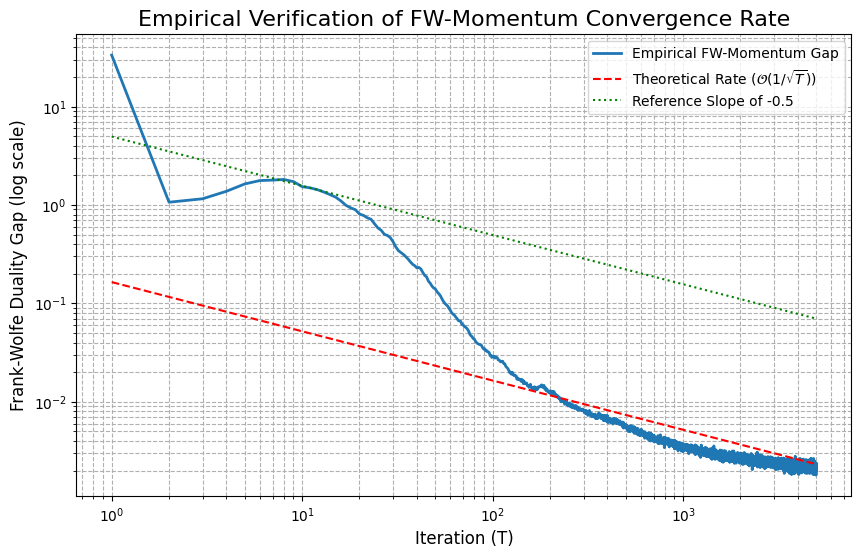

In [34]:
def fw_momentum_convergence_analysis(
    model,
    x_ori,
    y_target,
    epsilon,
    num_iterations,
    norm='linf',
    beta=0.90,
    stepsize_method='decreasing',
    num_line_search_steps=10
):
    """
    Runs FW attack with momentum to analyze convergence, returning the duality gaps.
    """
    x = x_ori.clone().detach()
    gaps = []

    # Initialize momentum
    x.requires_grad_(True)
    loss = F.cross_entropy(model(x), y_target)
    model.zero_grad()
    loss.backward()
    m = x.grad.detach().clone()
    x = x.detach()

    for t in range(num_iterations):
        x.requires_grad_(True)
        output = model(x)
        loss = F.cross_entropy(output, y_target)

        model.zero_grad()
        loss.backward()
        grad = x.grad.detach()
        x = x.detach()

        # Momentum update
        m = beta * m + (1 - beta) * grad

        # LMO with momentum direction
        s_t = lmo(m, x_ori, epsilon, norm)

        # Duality Gap Calculation
        gap = torch.dot(grad.flatten(), (x - s_t).flatten()).item()
        gaps.append(gap)

        d_t = s_t - x

        # Step Size Logic
        if stepsize_method == 'decreasing':
            gamma = 2.0 / (t + 2)
        elif stepsize_method == 'line_search':
            gamma = 0.0
            min_loss = float('inf')
            for g in torch.linspace(0, 1, steps=num_line_search_steps):
                x_cand = x + g * d_t
                x_cand = torch.clamp(x_cand, 0, 1)
                with torch.no_grad():
                    loss_cand = F.cross_entropy(model(x_cand), y_target)
                if loss_cand < min_loss:
                    min_loss = loss_cand
                    gamma = g
        else: # Default to decreasing step size
            gamma = 2.0 / (t + 2)

        # Update
        x = x + gamma * d_t
        x = torch.clamp(x, 0, 1)

    return gaps

# Parameters
image_to_attack = correctly_classified_images[0].to(device)
target_label = original_labels[0].to(device)
target_label_imagenet = target_labels[0].to(device)

num_iterations_analysis = 5000
epsilon_analysis_linf = 0.005

# --- Run Analysis ---
print("Running Frank-Wolfe convergence analysis...")
gaps_decreasing = fw_momentum_convergence_analysis(
    model=model,
    x_ori=image_to_attack,
    y_target=target_label_imagenet,
    epsilon=epsilon_analysis_linf,
    num_iterations=num_iterations_analysis,
    stepsize_method='decreasing'
)
print("Analysis complete.")

# --- Plotting ---
iterations = np.arange(1, num_iterations_analysis + 1)

# Estimate the constant C for the theoretical rate C/sqrt(T)
# using the final gap to get a rough estimate for C
# Add a small epsilon to avoid taking log of zero or negative gap
positive_gaps = [g + 1e-9 for g in gaps_decreasing if g > 0]
if not positive_gaps:
    print("Warning: No positive gaps found to plot.")
else:
    C = positive_gaps[-1] * np.sqrt(len(positive_gaps))
    theoretical_rate = C / np.sqrt(iterations)

    plt.figure(figsize=(10, 6))
    plt.loglog(iterations, gaps_decreasing, label='Empirical FW-Momentum Gap', linewidth=2)
    plt.loglog(iterations, theoretical_rate, label=r'Theoretical Rate ($\mathcal{O}(1/\sqrt{T})$)', linestyle='--', color='red')

    # Plot a line with slope -0.5 for visual comparison
    # Start from a later iteration to avoid initial noise
    if len(positive_gaps) > 10:
        log_y_start = np.log10(positive_gaps[10])
        log_x_start = np.log10(iterations[10])
        y_fit = 10**(log_y_start) * (iterations / iterations[10])**(-0.5) # power-law equation y = C * x^m where the slope m is -0.5
        plt.loglog(iterations, y_fit, label='Reference Slope of -0.5', linestyle=':', color='green')

    plt.title('Empirical Verification of FW-Momentum Convergence Rate', fontsize=16)
    plt.xlabel('Iteration (T)', fontsize=12)
    plt.ylabel('Frank-Wolfe Duality Gap (log scale)', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

# Plots and tables

## MNIST

In [ ]:
import pandas as pd

file_path = '/content/mnist_table.csv'
df = pd.read_csv(file_path)

df

Method   Norm     Stepsize     Stopping  Alpha  Momentum  Epsilon  \
0   FW-Standard  L_inf   decreasing      success    NaN       NaN    0.256   
1   FW-Standard  L_inf   decreasing  duality_gap    NaN       NaN    0.256   
2   FW-Standard  L_inf  line_search      success    NaN       NaN    0.256   
3   FW-Standard  L_inf  line_search  duality_gap    NaN       NaN    0.256   
4   FW-Standard     L2   decreasing      success    NaN       NaN    2.500   
5   FW-Standard     L2   decreasing  duality_gap    NaN       NaN    2.500   
6   FW-Standard     L2  line_search      success    NaN       NaN    2.500   
7   FW-Standard     L2  line_search  duality_gap    NaN       NaN    2.500   
8   FW-Momentum  L_inf   decreasing      success    NaN       0.9    0.256   
9   FW-Momentum  L_inf   decreasing  duality_gap    NaN       0.9    0.256   
10  FW-Momentum  L_inf  line_search      success    NaN       0.9    0.256   
11  FW-Momentum  L_inf  line_search  duality_gap    NaN       0.9    0.256   
12  FW-Momentum     L2   decreasing      success    NaN       0.9    2.500   
13  FW-Momentum     L2   decreasing  duality_gap    NaN       0.9    2.500   
14  FW-Momentum     L2  line_search      success    NaN       0.9    2.500   
15  FW-Momentum     L2  line_search  duality_gap    NaN       0.9    2.500   
16  FW-Pairwise  L_inf   decreasing      success    NaN       NaN    0.256   
17  FW-Pairwise  L_inf   decreasing  duality_gap    NaN       NaN    0.256   
18  FW-Pairwise  L_inf  line_search      success    NaN       NaN    0.256   
19  FW-Pairwise  L_inf  line_search  duality_gap    NaN       NaN    0.256   
20  FW-Pairwise     L2   decreasing      success    NaN       NaN    2.500   
21  FW-Pairwise     L2   decreasing  duality_gap    NaN       NaN    2.500   
22  FW-Pairwise     L2  line_search      success    NaN       NaN    2.500   
23  FW-Pairwise     L2  line_search  duality_gap    NaN       NaN    2.500   
24  FW-AwayStep  L_inf   decreasing      success    NaN       NaN    0.256   
25  FW-AwayStep  L_inf   decreasing  duality_gap    NaN       NaN    0.256   
26  FW-AwayStep  L_inf  line_search      success    NaN       NaN    0.256   
27  FW-AwayStep  L_inf  line_search  duality_gap    NaN       NaN    0.256   
28  FW-AwayStep     L2   decreasing      success    NaN       NaN    2.500   
29  FW-AwayStep     L2   decreasing  duality_gap    NaN       NaN    2.500   
30  FW-AwayStep     L2  line_search      success    NaN       NaN    2.500   
31  FW-AwayStep     L2  line_search  duality_gap    NaN       NaN    2.500   
32          PGD  L_inf  line_search      success  0.010       NaN    0.256   
33          PGD  L_inf  line_search          rho  0.010       NaN    0.256   
34          PGD     L2  line_search      success  0.125       NaN    2.500   
35          PGD     L2  line_search          rho  0.125       NaN    2.500   
36      MI-FGSM  L_inf  line_search      success  0.010       0.9    0.256   
37      MI-FGSM  L_inf  line_search          rho  0.010       0.9    0.256   
38      MI-FGSM     L2  line_search      success  0.125       0.9    2.500   
39      MI-FGSM     L2  line_search          rho  0.125       0.9    2.500   

    Avg. Distorsion  ASR (%)  Avg. Iterations  Total Time (s)  
0            0.2560    100.0             2.71            1.15  
1            0.2560    100.0            14.20            4.53  
2            0.2462     95.0             4.02            5.05  
3            0.2531     95.0            17.25           20.57  
4            2.3085     85.0            11.12            3.42  
5            2.4285     85.0            33.28            9.88  
6            2.4006     80.0            11.33           13.66  
7            2.4261     80.0            32.67           38.93  
8            0.2560    100.0             2.52            1.36  
9            0.2560    100.0            32.10            9.58  
10           0.2477    100.0             2.23            3.21  
11           0.2547    100.0            16

In [ ]:
# filtrato per L_inf, line search e duality gap/rho (i più importanti credo)

filtered_df = df[
    (df['Norm'] == 'L_inf') &
    (df['Stepsize'] == 'line_search') &
    (df['Stopping'].isin(['duality_gap', 'rho']))
]

filtered_df

# COMMENTI:
# tutti usano quasi tutta la distorsione possibile (molto vicino al limite)
# fw con momentum e PGD (e di poco meno MI-FGSM) miglior per success rate
# fw con momentum è quello che converge in meno iterazioni e anche minor computational time
# nel complesso è il migliore

Method   Norm     Stepsize     Stopping  Alpha  Momentum  Epsilon  \
3   FW-Standard  L_inf  line_search  duality_gap    NaN       NaN    0.256   
11  FW-Momentum  L_inf  line_search  duality_gap    NaN       0.9    0.256   
19  FW-Pairwise  L_inf  line_search  duality_gap    NaN       NaN    0.256   
27  FW-AwayStep  L_inf  line_search  duality_gap    NaN       NaN    0.256   
33          PGD  L_inf  line_search          rho   0.01       NaN    0.256   
37      MI-FGSM  L_inf  line_search          rho   0.01       0.9    0.256   

    Avg. Distorsion  ASR (%)  Avg. Iterations  Total Time (s)  
3            0.2531     95.0            17.25           20.57  
11           0.2547    100.0            16.35           20.23  
19           0.2355     95.0            28.88           38.60  
27           0.2545     91.0            30.84           41.28  
33           0.2543    100.0            36.89           52.63  
37           0.2553     98.0            37.81           53.28

In [ ]:
# filtrato per L_inf, line search e success per fare il paragone con quello di prima che usava duality gap

filtered_df = df[
    (df['Norm'] == 'L_inf') &
    (df['Stepsize'] == 'line_search') &
    (df['Stopping'].isin(['success']))
]

filtered_df

# COMMENTI:
# usando il metodo success risultati simili; success rate praticamente uguale a quello con duality gap per tutti
# e fw con momentum è ancora il migliore sia per success rate che iterazioni/tempo
# molto più veloce sia per iter che per tempo rispetto a duality gap ma perché non cerca il punto ottimale

Method   Norm     Stepsize Stopping  Alpha  Momentum  Epsilon  \
2   FW-Standard  L_inf  line_search  success    NaN       NaN    0.256   
10  FW-Momentum  L_inf  line_search  success    NaN       0.9    0.256   
18  FW-Pairwise  L_inf  line_search  success    NaN       NaN    0.256   
26  FW-AwayStep  L_inf  line_search  success    NaN       NaN    0.256   
32          PGD  L_inf  line_search  success   0.01       NaN    0.256   
36      MI-FGSM  L_inf  line_search  success   0.01       0.9    0.256   

    Avg. Distorsion  ASR (%)  Avg. Iterations  Total Time (s)  
2            0.2462     95.0             4.02            5.05  
10           0.2477    100.0             2.23            3.21  
18           0.2352     95.0             4.44            6.07  
26           0.2518     90.0             6.27            8.06  
32           0.1648    100.0            15.88           23.76  
36           0.1717     98.0            16.99           25.48

In [ ]:
# filtrato per fare paragone tra decreasing stepsize e line search per tutti i FW

filtered_df = df[
    (df['Norm'] == 'L_inf') &
    (df['Method'].str.contains('FW')) &
    (df['Stepsize'].isin(['decreasing', 'line_search'])) &
    (df['Stopping'] == 'duality_gap')
]

filtered_df

# COMMENTI
# decreasing ha sempre max distorsione pari a epsilon, mentre line search sta sempre un po' sotto
# decreasing migliora success rate per fw standard e away step
# numero di iterazioni comparabile, computational time invece molto più alto per line search ma ce lo si aspetta

Method   Norm     Stepsize     Stopping  Alpha  Momentum  Epsilon  \
1   FW-Standard  L_inf   decreasing  duality_gap    NaN       NaN    0.256   
3   FW-Standard  L_inf  line_search  duality_gap    NaN       NaN    0.256   
9   FW-Momentum  L_inf   decreasing  duality_gap    NaN       0.9    0.256   
11  FW-Momentum  L_inf  line_search  duality_gap    NaN       0.9    0.256   
17  FW-Pairwise  L_inf   decreasing  duality_gap    NaN       NaN    0.256   
19  FW-Pairwise  L_inf  line_search  duality_gap    NaN       NaN    0.256   
25  FW-AwayStep  L_inf   decreasing  duality_gap    NaN       NaN    0.256   
27  FW-AwayStep  L_inf  line_search  duality_gap    NaN       NaN    0.256   

    Avg. Distorsion  ASR (%)  Avg. Iterations  Total Time (s)  
1            0.2560    100.0            14.20            4.53  
3            0.2531     95.0            17.25           20.57  
9            0.2560    100.0            32.10            9.58  
11           0.2547    100.0            16.35           20.23  
17           0.2560     94.0            29.94            9.10  
19           0.2355     95.0            28.88           38.60  
25           0.2561    100.0            25.57           10.31  
27           0.2545     91.0            30.84           41.28